In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/environmental-sound-classification-50/utils2.py
/kaggle/input/environmental-sound-classification-50/esc50.csv
/kaggle/input/environmental-sound-classification-50/bc_utils.py
/kaggle/input/environmental-sound-classification-50/utils.py
/kaggle/input/environmental-sound-classification-50/audio/audio/5-257349-A-15.wav
/kaggle/input/environmental-sound-classification-50/audio/audio/5-195557-A-19.wav
/kaggle/input/environmental-sound-classification-50/audio/audio/2-122820-B-36.wav
/kaggle/input/environmental-sound-classification-50/audio/audio/1-115920-A-22.wav
/kaggle/input/environmental-sound-classification-50/audio/audio/1-172649-C-40.wav
/kaggle/input/environmental-sound-classification-50/audio/audio/2-50668-A-41.wav
/kaggle/input/environmental-sound-classification-50/audio/audio/3-119120-E-48.wav
/kaggle/input/environmental-sound-classification-50/audio/audio/1-223162-A-25.wav
/kaggle/input/environmental-sound-classification-50/audio/audio/3-119459-A-26.wav
/kaggle/input/

In [2]:
# =========================
# Cell 1 — Setup & Dataset bootstrap (Kaggle)
# =========================

# Core
import os, sys, gc, math, random, warnings, time, glob
warnings.filterwarnings("ignore")

# Numerics / data
import numpy as np
import pandas as pd

# Audio
import torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F

# Viz (used later)
import matplotlib.pyplot as plt

# Metrics / splits (used later)
from sklearn.model_selection import StratifiedKFold

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------
# Paths (Kaggle)
# -------------------------
DATASET_ROOT = "/kaggle/input/environmental-sound-classification-50"
CSV_PATH = os.path.join(DATASET_ROOT, "esc50.csv")

# The Kaggle pack lists files directly under /audio/audio/*.wav
# (But we’ll robustly search for .wav files in /audio)
AUDIO_ROOT = os.path.join(DATASET_ROOT, "audio")
if not os.path.exists(AUDIO_ROOT):
    raise FileNotFoundError(f"Expected audio root at {AUDIO_ROOT} not found.")

# Some packs have nested folders, others flat; search recursively:
WAV_FILES = sorted(glob.glob(os.path.join(AUDIO_ROOT, "**", "*.wav"), recursive=True))
if len(WAV_FILES) == 0:
    raise FileNotFoundError(
        f"No .wav files found under {AUDIO_ROOT}. "
        "Check dataset structure in this Kaggle environment."
    )

# -------------------------
# Config
# -------------------------
CFG = dict(
    SAMPLE_RATE=16000,     # user preference: 16 kHz (interpreted as 16,000 Hz)
    N_MELS=64,
    N_FFT=1024,
    HOP_LENGTH=160,        # 10 ms hop at 16 kHz
    WIN_LENGTH=400,        # 25 ms window at 16 kHz
    F_MIN=20,
    F_MAX=8000,
    N_CLASSES=50,
    MAX_SEC=5.0,           # ESC-50 clips are 5s
    FOLDS=5,               # official protocol
    DEVICE="cuda" if torch.cuda.is_available() else "cpu",
)

# -------------------------
# Metadata
# -------------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"esc50.csv not found at {CSV_PATH}")

meta = pd.read_csv(CSV_PATH)
required_cols = {"filename", "fold", "target", "category"}
missing = required_cols - set(meta.columns)
if missing:
    raise ValueError(f"esc50.csv is missing required columns: {missing}")

# Attach absolute file paths (robust to nested audio structure)
# The CSV filenames are like '1-100032-A-0.wav'
name_to_path = {os.path.basename(p): p for p in WAV_FILES}
meta["filepath"] = meta["filename"].map(name_to_path)

# Sanity checks
missing_paths = meta["filepath"].isna().sum()
if missing_paths > 0:
    # Attempt a case-insensitive rescue if filesystem differences exist
    lower_map = {os.path.basename(p).lower(): p for p in WAV_FILES}
    meta.loc[meta["filepath"].isna(), "filepath"] = meta.loc[meta["filepath"].isna(), "filename"].str.lower().map(lower_map)

missing_paths = meta["filepath"].isna().sum()
if missing_paths > 0:
    # If still missing, drop them with a clear message (should be zero for Kaggle pack)
    print(f"[WARN] {missing_paths} files from CSV were not found in the audio folder and will be dropped.")
    meta = meta[meta["filepath"].notna()].reset_index(drop=True)

# Basic dataset summary prints (no plots yet)
n_total = len(meta)
n_classes = meta["target"].nunique()
folds_present = sorted(meta["fold"].unique().tolist())
ex_paths_preview = meta["filepath"].head(3).tolist()

print("==== ESC-50 (Kaggle) — Bootstrap ====")
print(f"Total rows in CSV: {n_total}")
print(f"Unique classes (targets): {n_classes}")
print(f"Folds present: {folds_present}")
print(f"Sample rate (to be used): {CFG['SAMPLE_RATE']}")
print(f"Example files:\n  - " + "\n  - ".join(ex_paths_preview))

# Quick class validation
if n_classes != CFG["N_CLASSES"]:
    print(f"[WARN] Expected {CFG['N_CLASSES']} classes, but found {n_classes} in CSV.")

# Save label maps for later
IDX2LABEL = dict(sorted(meta[["target", "category"]].drop_duplicates().values.tolist()))
LABEL2IDX = {v: k for k, v in IDX2LABEL.items()}

# Keep only the columns we’ll need downstream
meta = meta[["filename", "filepath", "fold", "target", "category"]].reset_index(drop=True)

# Lightweight audio loader test (read one file, resample to 16 kHz)
test_path = meta["filepath"].iloc[0]
wav, sr = torchaudio.load(test_path)  # (channels, samples)
if sr != CFG["SAMPLE_RATE"]:
    resampler = torchaudio.transforms.Resample(sr, CFG["SAMPLE_RATE"])
    wav = resampler(wav)
print(f"Probe read OK: {os.path.basename(test_path)} | orig_sr={sr} -> used_sr={CFG['SAMPLE_RATE']} | shape={tuple(wav.shape)}")

# Free any large temps
del wav
gc.collect()

==== ESC-50 (Kaggle) — Bootstrap ====
Total rows in CSV: 2000
Unique classes (targets): 50
Folds present: [1, 2, 3, 4, 5]
Sample rate (to be used): 16000
Example files:
  - /kaggle/input/environmental-sound-classification-50/audio/audio/44100/1-100032-A-0.wav
  - /kaggle/input/environmental-sound-classification-50/audio/audio/44100/1-100038-A-14.wav
  - /kaggle/input/environmental-sound-classification-50/audio/audio/44100/1-100210-A-36.wav
Probe read OK: 1-100032-A-0.wav | orig_sr=44100 -> used_sr=16000 | shape=(1, 80000)


0

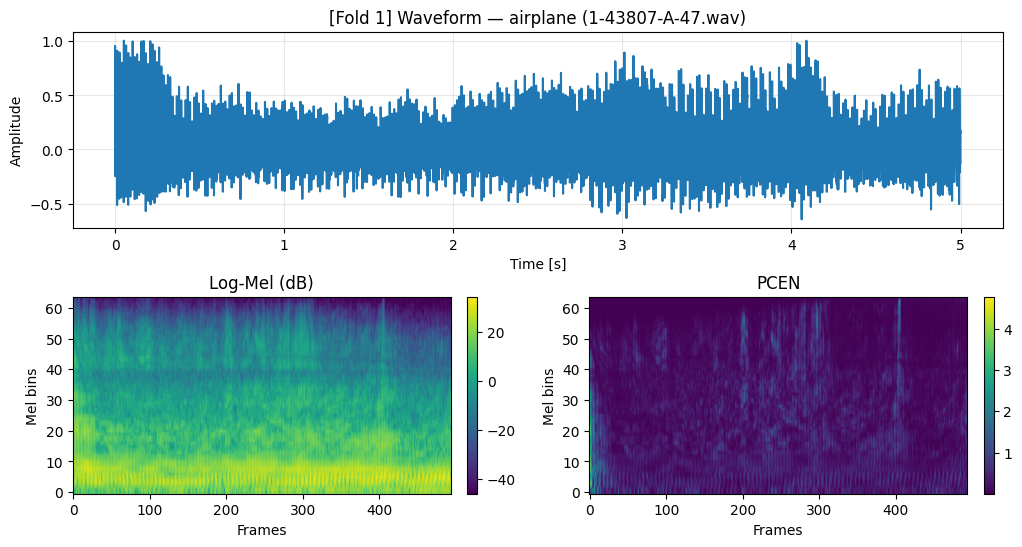

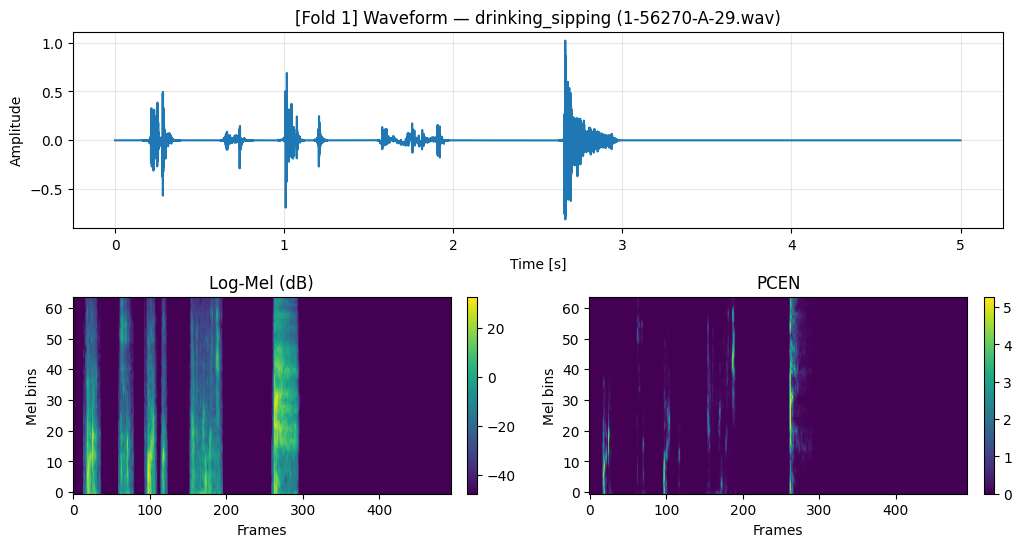

Feature tensor shape (C, n_mels, T): (2, 64, 494) ; label: 22
PCEN backend: librosa


In [3]:
# =========================
# Cell 2 — Feature pipeline (ALL-IN-ONE, replaces previous Cell 2 + 2.1)
# =========================
# - Robust PCEN fallback (torchaudio.functional / torchaudio.transforms / librosa)
# - Clean feature shapes (C, n_mels, T)
# - SpecAugment (freq/time masking)
# - Dataset class with per-channel standardization
# - Official fold splitter
# - Quick waveform + spectrogram previews

import math, random, gc
from typing import Tuple, List, Any, Optional
from dataclasses import dataclass

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.utils.data as tud
import torchaudio
import librosa
import matplotlib.pyplot as plt

# -------------------------
# Config (uses CFG from Cell 1)
# -------------------------
@dataclass
class AudioCfg:
    sample_rate: int = CFG["SAMPLE_RATE"]      # 16000
    max_sec: float = CFG["MAX_SEC"]            # 5.0
    n_fft: int = CFG["N_FFT"]                  # 1024
    hop_length: int = CFG["HOP_LENGTH"]        # 160  (10 ms @ 16k)
    win_length: int = CFG["WIN_LENGTH"]        # 400  (25 ms @ 16k)
    n_mels: int = CFG["N_MELS"]                # 64
    f_min: int = CFG["F_MIN"]                  # 20
    f_max: int = CFG["F_MAX"]                  # 8000
    center: bool = False
    power: float = 2.0                         # power mel
    top_db: Optional[float] = 80.0             # for AmplitudeToDB
    use_pcen: bool = True                      # add PCEN as a second channel

    # SpecAugment (applied only when augment=True)
    time_mask_param: int = 40
    freq_mask_param: int = 8
    n_time_masks: int = 2
    n_freq_masks: int = 2

AUDIOCFG = AudioCfg()

# -------------------------
# Reusable transforms
# -------------------------
_mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=AUDIOCFG.sample_rate,
    n_fft=AUDIOCFG.n_fft,
    hop_length=AUDIOCFG.hop_length,
    win_length=AUDIOCFG.win_length,
    f_min=AUDIOCFG.f_min,
    f_max=AUDIOCFG.f_max,
    n_mels=AUDIOCFG.n_mels,
    center=AUDIOCFG.center,
    power=AUDIOCFG.power,
)
_to_db = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=AUDIOCFG.top_db)
_resamplers = {}

# -------------------------
# Helper fns
# -------------------------
def _to_mono(wav: torch.Tensor) -> torch.Tensor:
    # wav: (C, N)
    return wav if wav.size(0) == 1 else wav.mean(dim=0, keepdim=True)

def _resample_if_needed(wav: torch.Tensor, orig_sr: int, target_sr: int) -> torch.Tensor:
    if orig_sr == target_sr:
        return wav
    key = (orig_sr, target_sr)
    if key not in _resamplers:
        _resamplers[key] = torchaudio.transforms.Resample(orig_sr, target_sr)
    return _resamplers[key](wav)

def _ensure_length(wav: torch.Tensor, target_len: int) -> torch.Tensor:
    # wav: (1, N) -> pad/crop to target_len
    n = wav.shape[-1]
    if n == target_len:
        return wav
    if n < target_len:
        pad = target_len - n
        left = pad // 2
        right = pad - left
        return F.pad(wav, (left, right))
    start = (n - target_len) // 2
    return wav[..., start:start+target_len]

def _spec_augment(spec: torch.Tensor, cfg: AudioCfg, p: float = 0.75) -> torch.Tensor:
    """
    SpecAugment on (C, n_mels, T)
    """
    if random.random() > p:
        return spec
    x = spec.clone()
    for _ in range(cfg.n_freq_masks):
        x = torchaudio.transforms.FrequencyMasking(cfg.freq_mask_param)(x)
    for _ in range(cfg.n_time_masks):
        x = torchaudio.transforms.TimeMasking(cfg.time_mask_param)(x)
    return x

# -------------------------
# PCEN compatibility (functional / transform / librosa fallback)
# -------------------------
_HAS_TA_PCEN_FUNC  = hasattr(torchaudio.functional, "pcen")
_HAS_TA_PCEN_TRANS = hasattr(torchaudio.transforms, "PCEN")
_PCEN_BACKEND = "ta_func" if _HAS_TA_PCEN_FUNC else ("ta_transform" if _HAS_TA_PCEN_TRANS else "librosa")

if _PCEN_BACKEND == "ta_transform":
    _pcen_transform = torchaudio.transforms.PCEN(
        eps=1e-6, gain=0.98, bias=2.0, power=0.5, time_constant=0.4, trainable=False
    )

def _apply_pcen(mel_power: torch.Tensor, cfg: AudioCfg) -> torch.Tensor:
    """
    mel_power: (n_mels, T) power mel spectrogram
    returns:   (n_mels, T) PCEN
    """
    if _PCEN_BACKEND == "ta_func":
        mel_mag = mel_power.sqrt()
        return torchaudio.functional.pcen(
            mel_mag, sr=cfg.sample_rate, gain=0.98, bias=2.0, time_constant=0.4, eps=1e-6
        )
    elif _PCEN_BACKEND == "ta_transform":
        return _pcen_transform(mel_power)
    else:
        mel_np = mel_power.detach().cpu().numpy().astype(np.float32)
        pcen_np = librosa.pcen(
            mel_np,
            sr=int(cfg.sample_rate),
            hop_length=int(cfg.hop_length),
            gain=0.98, bias=2.0, power=0.5, time_constant=0.4, eps=1e-6,
        )
        return torch.from_numpy(pcen_np).to(mel_power.device, dtype=mel_power.dtype)

# -------------------------
# Feature extraction (returns (C, n_mels, T))
# -------------------------
@torch.no_grad()
def compute_features(path: str, cfg: AudioCfg) -> torch.Tensor:
    wav, sr = torchaudio.load(path)         # (C, N)
    wav = _to_mono(wav)                     # (1, N)
    wav = _resample_if_needed(wav, sr, cfg.sample_rate)
    wav = _ensure_length(wav, int(cfg.sample_rate * cfg.max_sec))

    mel = _mel_spec(wav).clamp_min(1e-10)   # (1, n_mels, T) power mel
    mel = mel.squeeze(0)                    # -> (n_mels, T)
    mel_db = _to_db(mel)                    # -> (n_mels, T)

    if cfg.use_pcen:
        pcen = _apply_pcen(mel, cfg)        # (n_mels, T)
        feats = torch.stack([mel_db, pcen], dim=0)  # (2, n_mels, T)
    else:
        feats = mel_db.unsqueeze(0)         # (1, n_mels, T)

    return feats

# -------------------------
# Dataset with per-channel standardization + optional SpecAugment
# -------------------------
class ESC50Dataset(tud.Dataset):
    def __init__(self, df: pd.DataFrame, cfg: AudioCfg, augment: bool = False):
        self.df = df.reset_index(drop=True)
        self.cfg = cfg
        self.augment = augment

    def __len__(self): return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        x = compute_features(row.filepath, self.cfg)  # (C, M, T)
        if self.augment:
            x = _spec_augment(x, self.cfg, p=0.9)

        # per-channel standardization
        C = x.shape[0]
        xv = x.view(C, -1)
        mean = xv.mean(dim=1, keepdim=True)
        std  = xv.std(dim=1, keepdim=True).clamp_min(1e-5)
        x = ((xv - mean) / std).view_as(x)

        y = int(row.target)
        return x, y

# -------------------------
# Official fold split helper
# -------------------------
def get_fold_split(meta_df: pd.DataFrame, fold_id: int) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Returns (train_df, val_df, test_df) using ESC-50 official folds.
    Hold out 'fold_id' as test. Split remaining into train/val (10% val stratified).
    """
    assert fold_id in [1,2,3,4,5], "fold_id must be 1..5"
    test_df = meta_df[meta_df.fold == fold_id].copy()
    remain  = meta_df[meta_df.fold != fold_id].copy()

    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
    y = remain["target"].values
    idx_tr, idx_va = next(splitter.split(remain, y))
    train_df = remain.iloc[idx_tr].reset_index(drop=True)
    val_df   = remain.iloc[idx_va].reset_index(drop=True)
    return train_df, val_df, test_df.reset_index(drop=True)

# -------------------------
# Quick visuals — 2 samples from fold 1
# -------------------------
def plot_wave_and_specs(row, cfg: AudioCfg, title_prefix: str = ""):
    wav, sr = torchaudio.load(row.filepath)
    wav = _to_mono(wav)
    wav = _resample_if_needed(wav, sr, cfg.sample_rate)
    wav = _ensure_length(wav, int(cfg.sample_rate * cfg.max_sec))

    t = torch.arange(wav.shape[-1]) / cfg.sample_rate
    feats = compute_features(row.filepath, cfg)  # (C, M, T)

    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 2, width_ratios=[1,1], height_ratios=[1,1], hspace=0.35, wspace=0.25)

    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(t.numpy(), wav[0].numpy())
    ax0.set_title(f"{title_prefix}Waveform — {row.category} ({os.path.basename(row.filename)})")
    ax0.set_xlabel("Time [s]"); ax0.set_ylabel("Amplitude"); ax0.grid(True, alpha=0.3)

    ax1 = fig.add_subplot(gs[1, 0])
    im1 = ax1.imshow(feats[0].numpy(), origin="lower", aspect="auto")
    ax1.set_title("Log-Mel (dB)"); ax1.set_xlabel("Frames"); ax1.set_ylabel("Mel bins")
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    ax2 = fig.add_subplot(gs[1, 1])
    if feats.shape[0] > 1:
        im2 = ax2.imshow(feats[1].numpy(), origin="lower", aspect="auto")
        ax2.set_title("PCEN"); ax2.set_xlabel("Frames"); ax2.set_ylabel("Mel bins")
        fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    else:
        ax2.axis("off"); ax2.set_title("PCEN disabled")

    plt.show()

# Preview
_preview_df = meta[meta.fold == 1].sample(2, random_state=SEED)
for _, r in _preview_df.iterrows():
    plot_wave_and_specs(r, AUDIOCFG, title_prefix="[Fold 1] ")

# Shape probe
tmp_feats, tmp_y = ESC50Dataset(meta.sample(1, random_state=SEED), AUDIOCFG, augment=False)[0]
print("Feature tensor shape (C, n_mels, T):", tuple(tmp_feats.shape), "; label:", tmp_y)
print("PCEN backend:", _PCEN_BACKEND)


One sample feature shape (C, n_mels, T): (2, 64, 494) | label: 22 | clapping


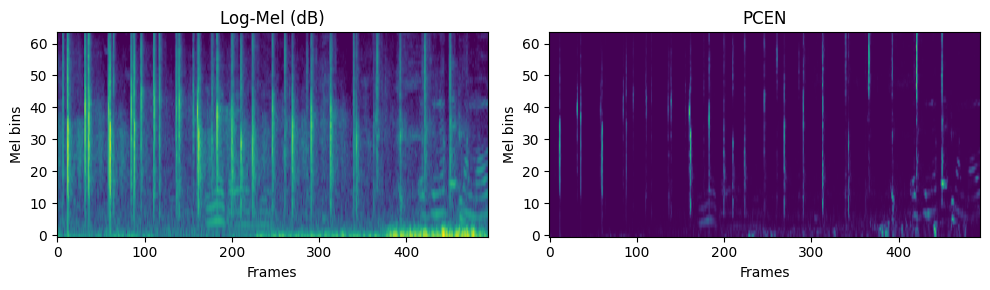

[Fold 1] sizes (train/val/test): (1440, 160, 400)
Batch shapes: (32, 2, 64, 494) (32,)


54291

In [4]:
# =========================
# Cell 3 — Clean feature shapes, collate, loaders, quick preview
# =========================

from typing import Tuple, List
import torch.utils.data as tud

# --- Override compute_features to ensure (C, n_mels, T) with no channel=1 dim ---
@torch.no_grad()
def compute_features(path: str, cfg: AudioCfg) -> torch.Tensor:
    wav, sr = torchaudio.load(path)  # (C, N)
    wav = _to_mono(wav)                              # -> (1, N)
    wav = _resample_if_needed(wav, sr, cfg.sample_rate)
    wav = _ensure_length(wav, int(cfg.sample_rate * cfg.max_sec))

    mel = _mel_spec(wav).clamp_min(1e-10)           # (1, n_mels, T)
    mel = mel.squeeze(0)                            # -> (n_mels, T)
    mel_db = _to_db(mel)                            # -> (n_mels, T)

    if AUDIOCFG.use_pcen:
        pcen = _apply_pcen(mel, cfg)                # (n_mels, T)
        feats = torch.stack([mel_db, pcen], dim=0)  # (2, n_mels, T)
    else:
        feats = mel_db.unsqueeze(0)                 # (1, n_mels, T)
    return feats

# --- Safe collate (pads T dimension if needed; usually constant for 5s clips) ---
def collate_spec(batch: List[Tuple[torch.Tensor, int]]) -> Tuple[torch.Tensor, torch.Tensor]:
    # batch: list of (C, n_mels, T), y
    Cs = [x[0].shape[0] for x in batch]
    Ms = [x[0].shape[1] for x in batch]
    Ts = [x[0].shape[2] for x in batch]
    assert len(set(Cs)) == 1 and len(set(Ms)) == 1, "Channel/mel dims must match within a batch."
    C, M = Cs[0], Ms[0]
    T_max = max(Ts)
    X = torch.zeros(len(batch), C, M, T_max, dtype=torch.float32)
    y = torch.tensor([t for _, t in batch], dtype=torch.long)
    for i, (feats, _) in enumerate(batch):
        T = feats.shape[2]
        X[i, :, :, :T] = feats
    return X, y

# --- Build train/val/test loaders for a given ESC-50 test fold ---
def make_loaders(fold_id: int, batch_size: int = 64, num_workers: int = 2):
    train_df, val_df, test_df = get_fold_split(meta, fold_id)

    train_ds = ESC50Dataset(train_df, AUDIOCFG, augment=True)
    val_ds   = ESC50Dataset(val_df,   AUDIOCFG, augment=False)
    test_ds  = ESC50Dataset(test_df,  AUDIOCFG, augment=False)

    loader_args = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers>0))
    train_ld = tud.DataLoader(train_ds, shuffle=True,  collate_fn=collate_spec, **loader_args)
    val_ld   = tud.DataLoader(val_ds,   shuffle=False, collate_fn=collate_spec, **loader_args)
    test_ld  = tud.DataLoader(test_ds,  shuffle=False, collate_fn=collate_spec, **loader_args)

    return train_ld, val_ld, test_ld, (len(train_ds), len(val_ds), len(test_ds))

# --- Quick preview: one sample after the new pipeline ---
row = meta.sample(1, random_state=SEED).iloc[0]
feats = compute_features(row.filepath, AUDIOCFG)    # (2, n_mels, T)
print("One sample feature shape (C, n_mels, T):", tuple(feats.shape), "| label:", row.target, "|", row.category)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].imshow(feats[0].numpy(), origin="lower", aspect="auto")
axes[0].set_title("Log-Mel (dB)")
axes[1].imshow(feats[1].numpy(), origin="lower", aspect="auto")
axes[1].set_title("PCEN")
for ax in axes: 
    ax.set_xlabel("Frames"); ax.set_ylabel("Mel bins")
plt.tight_layout()
plt.show()

# --- Dry-run the loaders for fold 1 to verify shapes ---
train_ld, val_ld, test_ld, sizes = make_loaders(fold_id=1, batch_size=32, num_workers=2)
print(f"[Fold 1] sizes (train/val/test): {sizes}")
xb, yb = next(iter(train_ld))
print("Batch shapes:", tuple(xb.shape), tuple(yb.shape))
del xb, yb; gc.collect()


Fold 1 sizes (train/val/test): (1440, 160, 400)
Epoch 01/12 | train loss 3.8699 acc 0.040 | val loss 3.9100 acc 0.031
Epoch 02/12 | train loss 3.7033 acc 0.094 | val loss 3.5233 acc 0.138
Epoch 03/12 | train loss 3.3978 acc 0.148 | val loss 3.8514 acc 0.094
Epoch 04/12 | train loss 3.0437 acc 0.191 | val loss 6.3147 acc 0.050
Epoch 05/12 | train loss 2.7469 acc 0.233 | val loss 2.7963 acc 0.250
Epoch 06/12 | train loss 2.5430 acc 0.299 | val loss 3.1287 acc 0.194
Epoch 07/12 | train loss 2.3870 acc 0.340 | val loss 2.5159 acc 0.294
Epoch 08/12 | train loss 2.2427 acc 0.381 | val loss 2.3448 acc 0.388
Epoch 09/12 | train loss 2.1318 acc 0.445 | val loss 2.3299 acc 0.400
Epoch 10/12 | train loss 2.0588 acc 0.467 | val loss 2.0695 acc 0.419
Epoch 11/12 | train loss 1.9957 acc 0.478 | val loss 2.0153 acc 0.494
Epoch 12/12 | train loss 2.0112 acc 0.484 | val loss 1.9865 acc 0.506
Training time: 237.7s


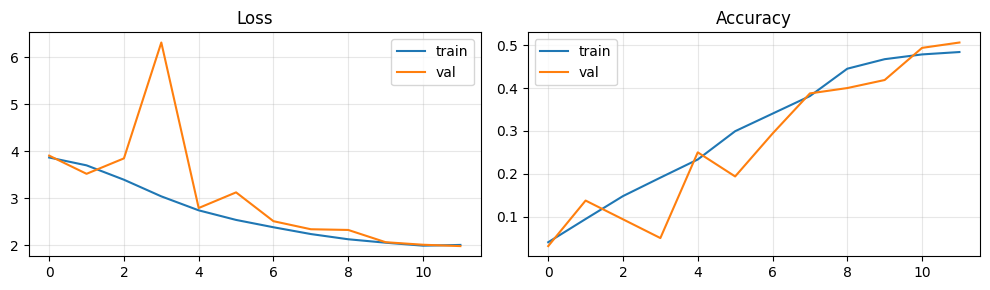

[Fold 1] Test accuracy: 0.450


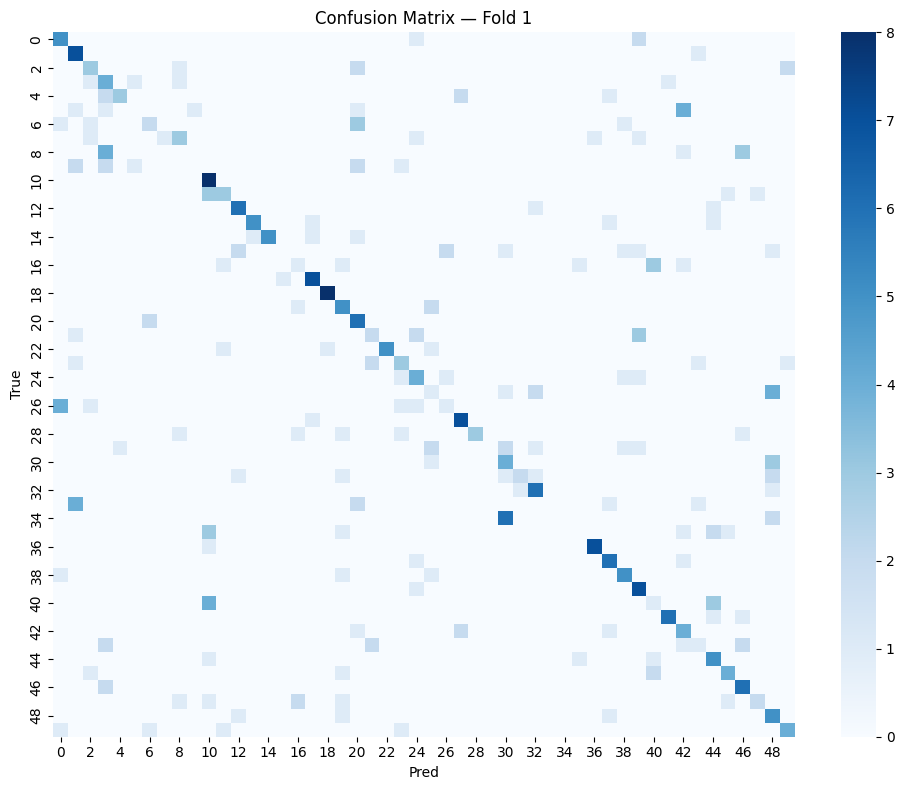

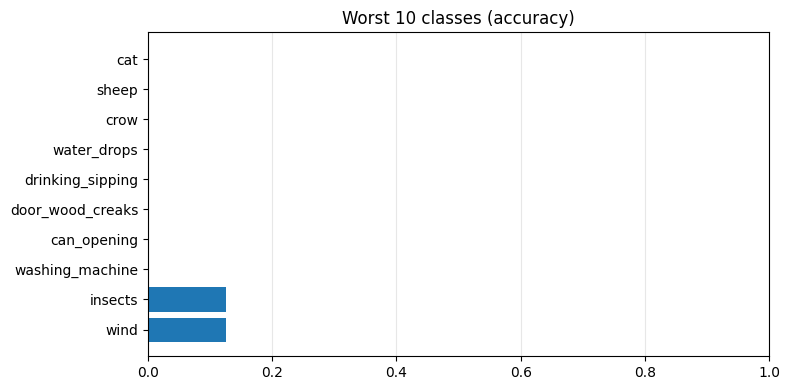

Done. Fold-1 accuracy: 0.45


In [5]:
# =========================
# Cell 4 — Model A (from-scratch CNN), trainer, fold-1 run, visuals
# =========================

import math, time
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

DEVICE = CFG["DEVICE"]

# -------------------------
# Model A — compact CNN with adaptive pooling
# -------------------------
class ConvBNAct(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=1, groups=1):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, k, s, p, bias=False, groups=groups)
        self.bn   = nn.BatchNorm2d(c_out)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class SEBlock(nn.Module):
    def __init__(self, ch, r=8):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(ch, ch//r, 1)
        self.fc2 = nn.Conv2d(ch//r, ch, 1)
    def forward(self, x):
        w = self.pool(x)
        w = F.relu(self.fc1(w), inplace=True)
        w = torch.sigmoid(self.fc2(w))
        return x * w

class AudioCNN(nn.Module):
    def __init__(self, n_classes=50, in_ch=2, width=32, p_drop=0.3):
        super().__init__()
        c1, c2, c3, c4 = width, width*2, width*3, width*4

        self.stem = ConvBNAct(in_ch, c1, k=5, s=1, p=2)

        self.block1 = nn.Sequential(
            ConvBNAct(c1, c1, k=3, s=1, p=1),
            ConvBNAct(c1, c1, k=3, s=1, p=1),
            SEBlock(c1),
            nn.AvgPool2d(kernel_size=(2,2))  # downsample F and T
        )
        self.block2 = nn.Sequential(
            ConvBNAct(c1, c2, k=3, s=1, p=1),
            ConvBNAct(c2, c2, k=3, s=1, p=1),
            SEBlock(c2),
            nn.AvgPool2d(kernel_size=(2,2))
        )
        self.block3 = nn.Sequential(
            ConvBNAct(c2, c3, k=3, s=1, p=1),
            ConvBNAct(c3, c3, k=3, s=1, p=1),
            SEBlock(c3),
            nn.AvgPool2d(kernel_size=(2,2))
        )
        self.block4 = nn.Sequential(
            ConvBNAct(c3, c4, k=3, s=1, p=1),
            SEBlock(c4)
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1),
            nn.Dropout(p_drop),
            nn.Linear(c4, n_classes)
        )

    def forward(self, x):
        # x: (B, 2, 64, T)
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.head(x)
        return x

# -------------------------
# Training utilities
# -------------------------
def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion, scaler, scheduler=None):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            scheduler.step()

        bs = xb.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, yb) * bs
        n += bs

    return total_loss / n, total_acc / n

@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)
        bs = xb.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, yb) * bs
        n += bs
    return total_loss / n, total_acc / n

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(yb.numpy().tolist())
    return np.array(y_true), np.array(y_pred)

# -------------------------
# Fit on one official test fold (fold 1), with internal val split
# -------------------------
def fit_fold_oneshot(fold_id=1, epochs=15, batch_size=64, lr=2e-3, wd=1e-4):
    train_ld, val_ld, test_ld, sizes = make_loaders(fold_id=fold_id, batch_size=batch_size, num_workers=2)
    print(f"Fold {fold_id} sizes (train/val/test): {sizes}")

    model = AudioCNN(n_classes=CFG["N_CLASSES"], in_ch=2, width=32, p_drop=0.35).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    try:
        criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    except TypeError:
        criterion = nn.CrossEntropyLoss()

    # OneCycleLR for smooth training
    steps_per_epoch = len(train_ld)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, steps_per_epoch=steps_per_epoch, epochs=epochs
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

    hist = defaultdict(list)
    best_val = np.inf
    best_state = None
    t0 = time.time()

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_ld, optimizer, criterion, scaler, scheduler)
        va_loss, va_acc = eval_one_epoch(model, val_ld, criterion)

        hist["tr_loss"].append(tr_loss); hist["tr_acc"].append(tr_acc)
        hist["va_loss"].append(va_loss); hist["va_acc"].append(va_acc)

        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(f"Epoch {ep:02d}/{epochs} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.3f}")

    t1 = time.time()
    print(f"Training time: {t1 - t0:.1f}s")

    if best_state is not None:
        model.load_state_dict(best_state)
    torch.save(model.state_dict(), f"/kaggle/working/modelA_fold{fold_id}.pt")

    # Curves
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    ax[0].plot(hist["tr_loss"], label="train"); ax[0].plot(hist["va_loss"], label="val")
    ax[0].set_title("Loss"); ax[0].legend(); ax[0].grid(True, alpha=0.3)
    ax[1].plot(hist["tr_acc"], label="train"); ax[1].plot(hist["va_acc"], label="val")
    ax[1].set_title("Accuracy"); ax[1].legend(); ax[1].grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # Test evaluation
    y_true, y_pred = predict_all(model, test_ld)
    test_acc = (y_true == y_pred).mean()
    print(f"[Fold {fold_id}] Test accuracy: {test_acc:.3f}")

    # Confusion matrix heatmap (labels hidden to keep it readable)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(CFG["N_CLASSES"])))
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap="Blues", cbar=True)
    plt.title(f"Confusion Matrix — Fold {fold_id}")
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

    # Worst 10 classes by accuracy
    per_class_acc = {}
    for c in range(CFG["N_CLASSES"]):
        idx = (y_true == c)
        if idx.sum() == 0:
            per_class_acc[c] = np.nan
        else:
            per_class_acc[c] = (y_pred[idx] == c).mean()
    worst = sorted(per_class_acc.items(), key=lambda kv: (np.nan_to_num(kv[1], nan=1.0)))[:10]
    w_labels = [IDX2LABEL[c] for c, _ in worst]
    w_scores = [a for _, a in worst]
    plt.figure(figsize=(8,4))
    plt.barh(w_labels, w_scores)
    plt.gca().invert_yaxis()
    plt.xlim(0,1); plt.title("Worst 10 classes (accuracy)")
    plt.grid(True, axis="x", alpha=0.3)
    plt.tight_layout(); plt.show()

    return model, test_acc

# -------------------------
# Run fold 1 demo (adjust epochs up later if desired)
# -------------------------
modelA, fold1_acc = fit_fold_oneshot(fold_id=1, epochs=12, batch_size=64, lr=2e-3, wd=1e-4)
print("Done. Fold-1 accuracy:", fold1_acc)


[Pretrained] Fold 1 sizes (train/val/test): (1440, 160, 400)


Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960.pth
100%|██████████| 360M/360M [00:01<00:00, 341MB/s] 


Backbone: Wav2Vec2Bundle | feat_dim: 768
Epoch 01/8 | train 3.8974/0.051 | val 3.3806/0.206
Epoch 02/8 | train 3.1106/0.187 | val 2.7424/0.319
Epoch 03/8 | train 2.5248/0.367 | val 2.4582/0.438
Epoch 04/8 | train 2.1599/0.457 | val 2.3409/0.438
Epoch 05/8 | train 1.9429/0.522 | val 2.1676/0.475
Epoch 06/8 | train 1.7601/0.582 | val 2.0722/0.494
Epoch 07/8 | train 1.6767/0.618 | val 2.0253/0.500
Epoch 08/8 | train 1.5943/0.640 | val 2.0211/0.525


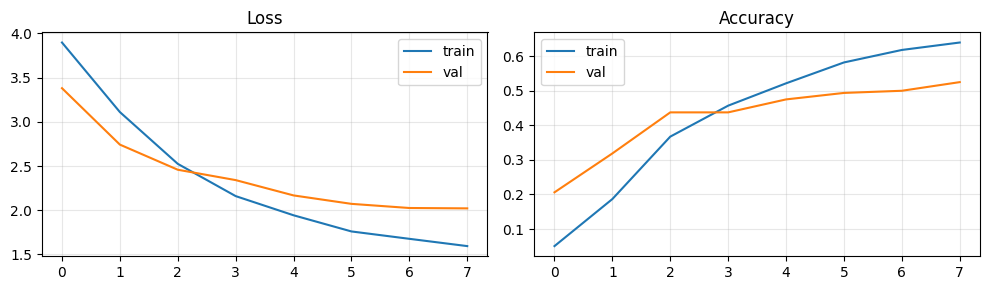

[Pretrained] Fold 1 test accuracy: 0.430


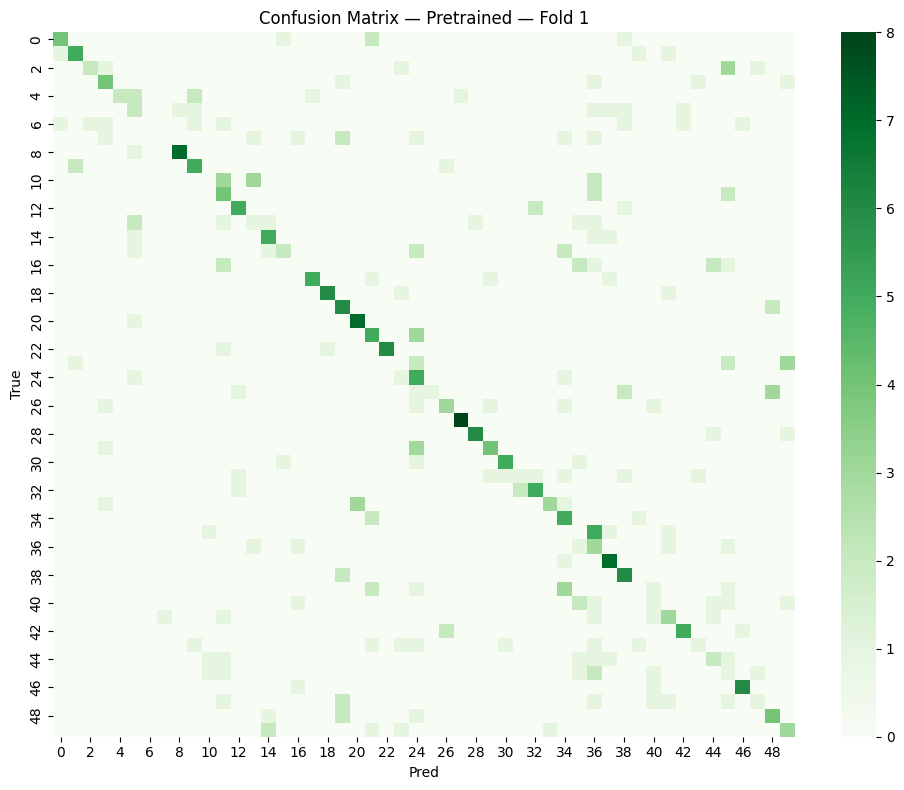

Done. Fold-1 (pretrained) accuracy: 0.43


In [6]:
# =========================
# Cell 5 — Model B (Pretrained backbone via torchaudio), wave loaders, train+viz
# =========================

import torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tud
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

DEVICE = CFG["DEVICE"]
TARGET_LEN = int(CFG["SAMPLE_RATE"] * CFG["MAX_SEC"])

# -------------------------
# Waveform dataset (16 kHz, 5 s, mono)
# -------------------------
class ESC50WaveDataset(tud.Dataset):
    def __init__(self, df: pd.DataFrame, sr: int = CFG["SAMPLE_RATE"], augment: bool = False):
        self.df = df.reset_index(drop=True)
        self.sr = sr
        self.augment = augment
        self._resamplers = {}

    def _resample(self, wav, sr):
        if sr == self.sr:
            return wav
        key = (sr, self.sr)
        if key not in self._resamplers:
            self._resamplers[key] = torchaudio.transforms.Resample(sr, self.sr)
        return self._resamplers[key](wav)

    def _to_mono(self, wav):
        return wav if wav.size(0) == 1 else wav.mean(dim=0, keepdim=True)

    def _ensure_len(self, wav):
        n = wav.shape[-1]
        if n == TARGET_LEN:
            return wav
        if n < TARGET_LEN:
            pad = TARGET_LEN - n
            left = pad // 2
            right = pad - left
            return F.pad(wav, (left, right))
        s = (n - TARGET_LEN) // 2
        return wav[..., s:s+TARGET_LEN]

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        wav, sr = torchaudio.load(row.filepath)
        wav = self._to_mono(wav)
        wav = self._resample(wav, sr)
        wav = self._ensure_len(wav)
        wav = wav[0]  # (T,)
        # light waveform augments (only for train)
        if self.augment:
            if np.random.rand() < 0.3:
                gain = float(np.random.uniform(0.8, 1.2))
                wav = torch.clamp(wav * gain, -1.0, 1.0)
            if np.random.rand() < 0.3:
                noise = torch.randn_like(wav) * 0.005
                wav = torch.clamp(wav + noise, -1.0, 1.0)
        return wav, int(row.target)

def collate_wave(batch):
    x = torch.stack([b[0] for b in batch], dim=0)  # (B, T)
    y = torch.tensor([b[1] for b in batch], dtype=torch.long)
    return x, y

def make_wave_loaders(fold_id: int, batch_size: int = 16, num_workers: int = 2):
    train_df, val_df, test_df = get_fold_split(meta, fold_id)
    train_ds = ESC50WaveDataset(train_df, augment=True)
    val_ds   = ESC50WaveDataset(val_df,   augment=False)
    test_ds  = ESC50WaveDataset(test_df,  augment=False)
    args = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers>0))
    train_ld = tud.DataLoader(train_ds, shuffle=True,  collate_fn=collate_wave, **args)
    val_ld   = tud.DataLoader(val_ds,   shuffle=False, collate_fn=collate_wave, **args)
    test_ld  = tud.DataLoader(test_ds,  shuffle=False, collate_fn=collate_wave, **args)
    return train_ld, val_ld, test_ld, (len(train_ds), len(val_ds), len(test_ds))

# -------------------------
# Pretrained backbone wrapper
# -------------------------
class PretrainedAudioBackbone(nn.Module):
    """
    Tries torchaudio.pipelines bundles in order; freezes backbone by default.
    Falls back to a small conv frontend if no bundle is available.
    """
    def __init__(self, n_classes=50, freeze_backbone=True, p_drop=0.4):
        super().__init__()
        self.backbone_name = None
        self.backbone = None
        self.feat_dim = None

        # Try torchaudio bundles (no internet required in many Kaggle images)
        candidates = [
            getattr(torchaudio.pipelines, "WAV2VEC2_BASE",         None),
            getattr(torchaudio.pipelines, "WAV2VEC2_ASR_BASE_960H",None),
            getattr(torchaudio.pipelines, "HUBERT_BASE",           None),
            getattr(torchaudio.pipelines, "WAVLM_BASE",            None),
        ]
        for bundle in candidates:
            if bundle is None: 
                continue
            try:
                self.backbone = bundle.get_model()
                self.backbone_name = str(bundle.__class__.__name__) if hasattr(bundle, "__class__") else str(bundle)
                break
            except Exception as e:
                self.backbone = None

        if self.backbone is None:
            # Fallback: light 1D conv encoder
            self.backbone_name = "FallbackConv1D"
            self.backbone = nn.Sequential(
                nn.Conv1d(1, 64, kernel_size=11, stride=5, padding=5),
                nn.BatchNorm1d(64), nn.ReLU(True),
                nn.Conv1d(64,128, kernel_size=9, stride=4, padding=4),
                nn.BatchNorm1d(128), nn.ReLU(True),
                nn.Conv1d(128,256,kernel_size=7, stride=2, padding=3),
                nn.BatchNorm1d(256), nn.ReLU(True),
            )
            self.feat_dim = 256
            self._forward_feats = self._forward_feats_conv
        else:
            if freeze_backbone:
                for p in self.backbone.parameters():
                    p.requires_grad_(False)
            self._forward_feats = self._forward_feats_bundle

        # infer feat_dim once with a dummy forward
        if self.feat_dim is None:
            with torch.no_grad():
                dummy = torch.zeros(2, TARGET_LEN)  # (B,T)
                x = self._forward_feats(dummy)
                self.feat_dim = x.shape[-1]

        self.head = nn.Sequential(
            nn.LayerNorm(self.feat_dim),
            nn.Dropout(p_drop),
            nn.Linear(self.feat_dim, n_classes),
        )

    def _forward_feats_bundle(self, wav: torch.Tensor):
        # wav: (B, T)
        m = self.backbone
        if hasattr(m, "extract_features"):
            feats, _ = m.extract_features(wav)  # list(L) of (B, T', C)
            x = feats[-1]
        else:
            x = m(wav)  # (B, T', C) for some bundles
        return x

    def _forward_feats_conv(self, wav: torch.Tensor):
        x = wav.unsqueeze(1)  # (B,1,T)
        x = self.backbone(x)  # (B,C,T')
        x = x.transpose(1,2)  # -> (B,T',C) to match bundle output convention
        return x

    def forward(self, wav):
        x = self._forward_feats(wav)   # (B, T', C)
        x = x.mean(dim=1)              # temporal mean pool -> (B, C)
        return self.head(x)

# -------------------------
# Training loops (reuse)
# -------------------------
def train_one_epoch_w(model, loader, optimizer, criterion, scaler, scheduler=None):
    model.train()
    tot_loss=tot_acc=n=0
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        scaler.step(optimizer); scaler.update()
        if scheduler is not None: scheduler.step()

        bs = xb.size(0)
        tot_loss += loss.item()*bs
        tot_acc  += (logits.argmax(1)==yb).float().sum().item()
        n += bs
    return tot_loss/n, tot_acc/n

@torch.no_grad()
def eval_one_epoch_w(model, loader, criterion):
    model.eval()
    tot_loss=tot_acc=n=0
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)
        bs = xb.size(0)
        tot_loss += loss.item()*bs
        tot_acc  += (logits.argmax(1)==yb).float().sum().item()
        n += bs
    return tot_loss/n, tot_acc/n

@torch.no_grad()
def predict_all_w(model, loader):
    model.eval()
    yp, yt = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb)
        yp.extend(logits.argmax(1).cpu().tolist())
        yt.extend(yb.cpu().tolist())
    return np.array(yt), np.array(yp)

# -------------------------
# Fit on one fold with pretrained backbone (frozen)
# -------------------------
def fit_fold_pretrained(fold_id=1, epochs=8, batch_size=16, lr=2e-3, wd=1e-4, unfreeze_last=False):
    train_ld, val_ld, test_ld, sizes = make_wave_loaders(fold_id=fold_id, batch_size=batch_size, num_workers=2)
    print(f"[Pretrained] Fold {fold_id} sizes (train/val/test): {sizes}")

    model = PretrainedAudioBackbone(n_classes=CFG["N_CLASSES"], freeze_backbone=not unfreeze_last).to(DEVICE)
    print("Backbone:", model.backbone_name, "| feat_dim:", model.feat_dim)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=wd)
    try:
        criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    except TypeError:
        criterion = nn.CrossEntropyLoss()

    steps_per_epoch = len(train_ld)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=steps_per_epoch, epochs=epochs)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

    tr_loss_hist, va_loss_hist, tr_acc_hist, va_acc_hist = [], [], [], []
    best_val, best_state = np.inf, None

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch_w(model, train_ld, optimizer, criterion, scaler, scheduler)
        va_loss, va_acc = eval_one_epoch_w(model, val_ld, criterion)

        tr_loss_hist.append(tr_loss); tr_acc_hist.append(tr_acc)
        va_loss_hist.append(va_loss); va_acc_hist.append(va_acc)

        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(f"Epoch {ep:02d}/{epochs} | "
              f"train {tr_loss:.4f}/{tr_acc:.3f} | "
              f"val {va_loss:.4f}/{va_acc:.3f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    torch.save(model.state_dict(), f"/kaggle/working/modelB_fold{fold_id}.pt")

    # Curves
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    ax[0].plot(tr_loss_hist, label="train"); ax[0].plot(va_loss_hist, label="val")
    ax[0].set_title("Loss"); ax[0].legend(); ax[0].grid(True, alpha=0.3)
    ax[1].plot(tr_acc_hist, label="train"); ax[1].plot(va_acc_hist, label="val")
    ax[1].set_title("Accuracy"); ax[1].legend(); ax[1].grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # Test
    yt, yp = predict_all_w(model, test_ld)
    acc = (yt==yp).mean()
    print(f"[Pretrained] Fold {fold_id} test accuracy: {acc:.3f}")

    cm = confusion_matrix(yt, yp, labels=list(range(CFG["N_CLASSES"])))
    plt.figure(figsize=(10,8)); sns.heatmap(cm, cmap="Greens", cbar=True)
    plt.title(f"Confusion Matrix — Pretrained — Fold {fold_id}")
    plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout(); plt.show()

    return model, acc

# -------------------------
# Run fold 1 (frozen backbone). If memory errors, reduce batch_size to 8.
# -------------------------
modelB, fold1_acc_B = fit_fold_pretrained(fold_id=1, epochs=8, batch_size=16, lr=2e-3, wd=1e-4, unfreeze_last=False)
print("Done. Fold-1 (pretrained) accuracy:", fold1_acc_B)

=== Model A (Spec-CNN) — Test metrics ===
Top-1 acc: 0.450 | Top-3 acc: 0.677


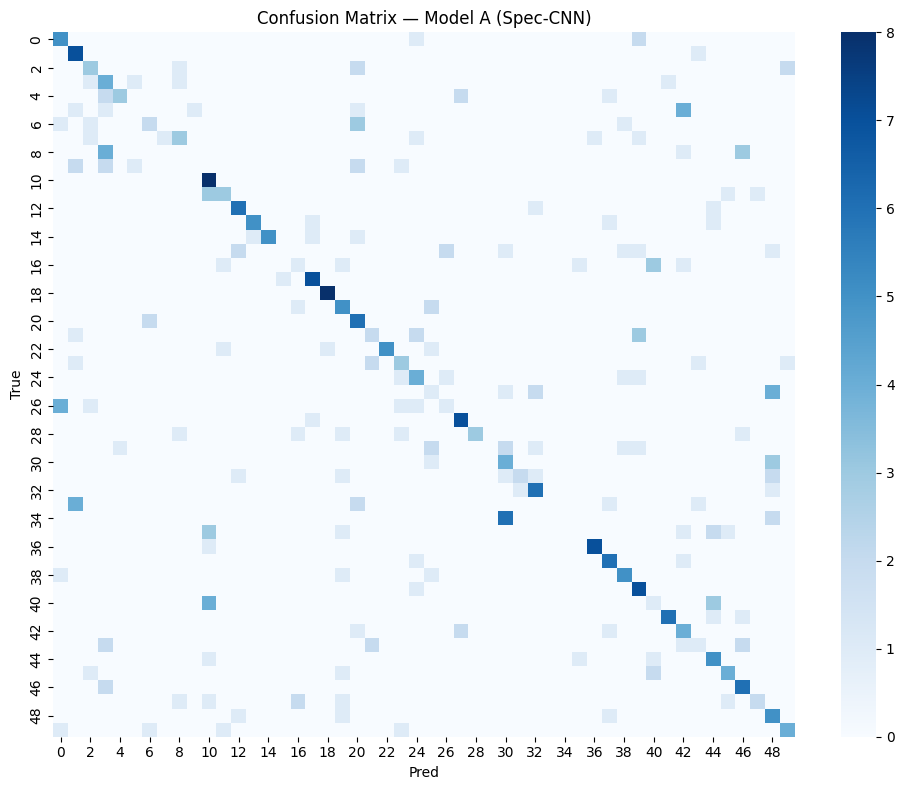

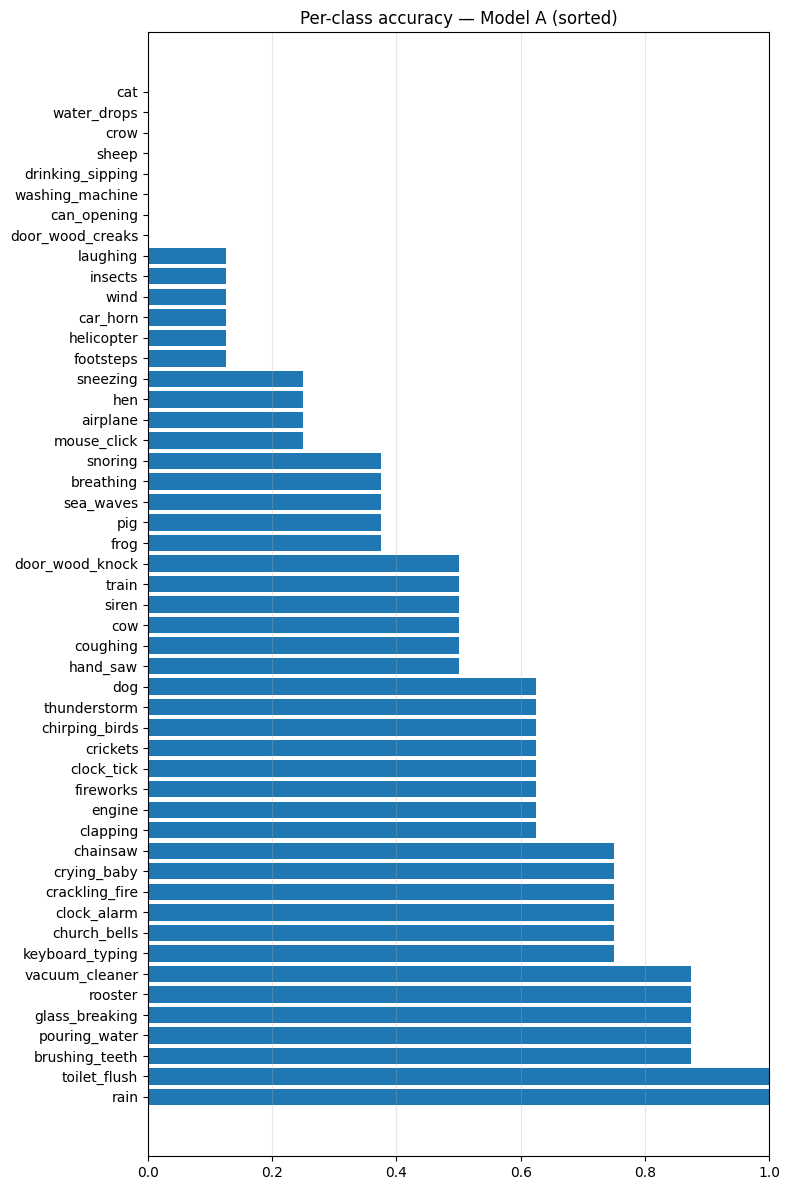

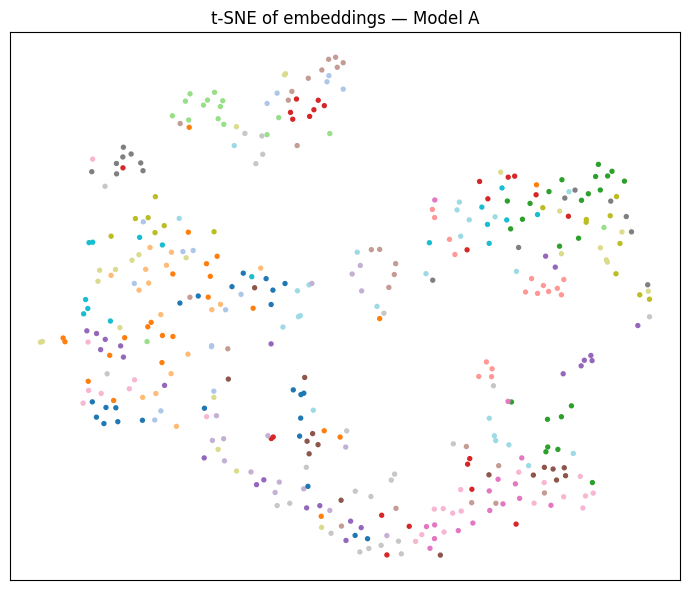

=== Model B (Pretrained) — Test metrics ===
Top-1 acc: 0.430 | Top-3 acc: 0.613


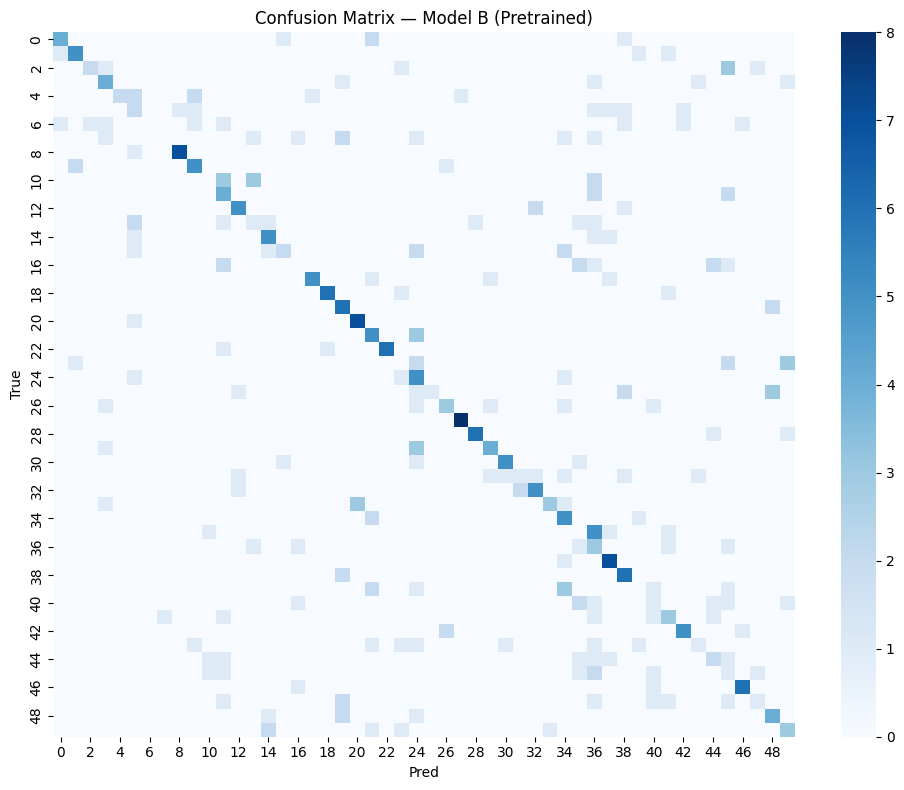

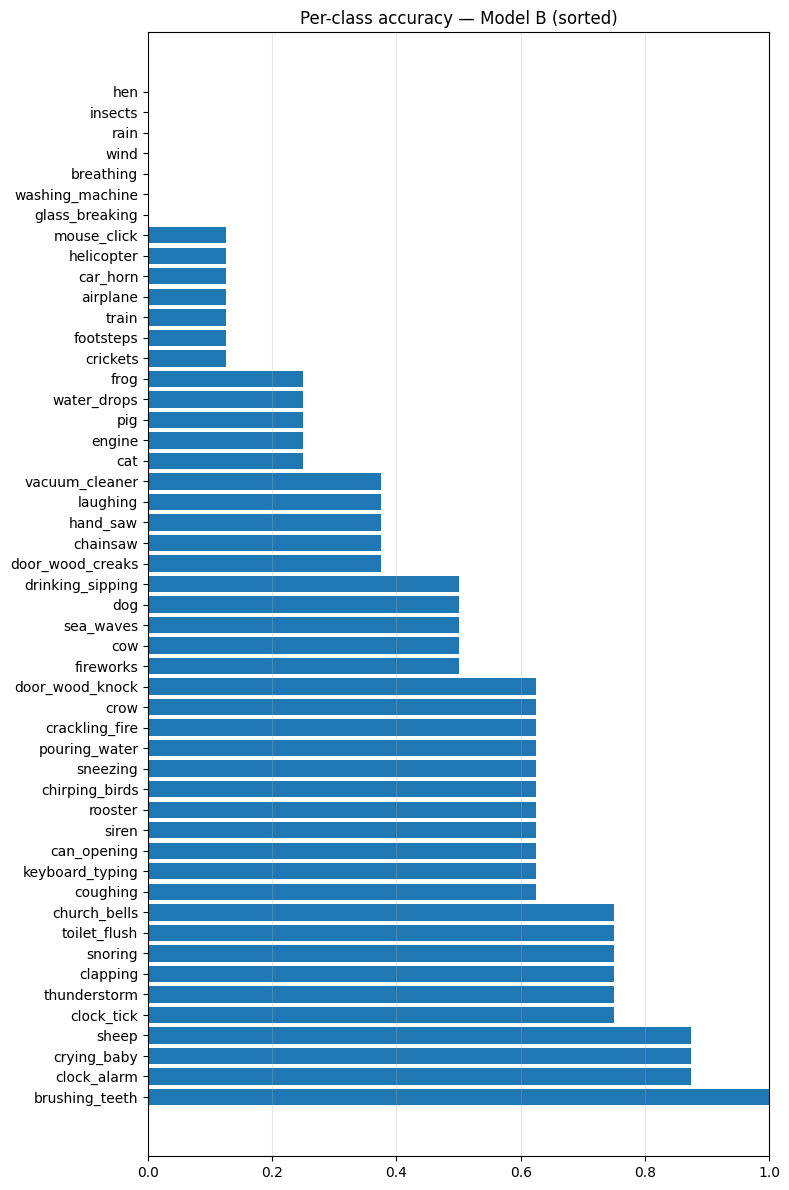

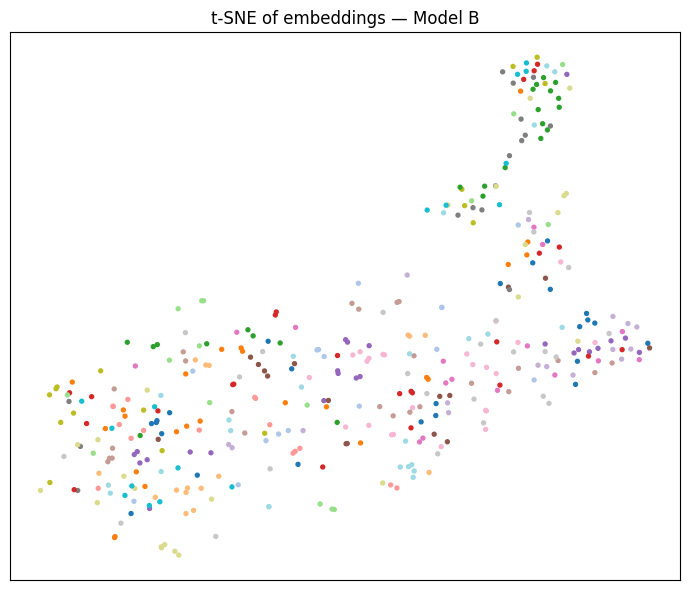

In [7]:
# =========================
# Cell 6 — Rich evaluation & visuals for Model A (spec-CNN) and Model B (pretrained)
# =========================
# - Unified metrics (accuracy, top-3)
# - Per-class accuracy bars (sorted)
# - Confusion matrices
# - 2D embedding plots (t-SNE) from penultimate features
# NOTE: Rebuilds the test loaders for fold=1 to keep things clean.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

DEVICE = CFG["DEVICE"]
FOLD = 1

# -------------------------
# Helper: evaluate + collect logits
# -------------------------
@torch.no_grad()
def _eval_with_logits_spec(model, loader):
    model.eval()
    ys, yp, all_logits = [], [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb)
        all_logits.append(logits.cpu())
        ys.extend(yb.numpy().tolist())
        yp.extend(logits.argmax(1).cpu().numpy().tolist())
    logits_cat = torch.cat(all_logits, dim=0).numpy()
    return np.array(ys), np.array(yp), logits_cat

@torch.no_grad()
def _eval_with_logits_wave(model, loader):
    model.eval()
    ys, yp, all_logits = [], [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb)
        all_logits.append(logits.cpu())
        ys.extend(yb.numpy().tolist())
        yp.extend(logits.argmax(1).cpu().numpy().tolist())
    logits_cat = torch.cat(all_logits, dim=0).numpy()
    return np.array(ys), np.array(yp), logits_cat

def topk_accuracy(logits_np: np.ndarray, y_true: np.ndarray, k: int = 3) -> float:
    topk = np.argpartition(-logits_np, kth=range(k), axis=1)[:, :k]
    hits = (topk == y_true.reshape(-1,1)).any(axis=1)
    return hits.mean()

def per_class_accuracy(y_true, y_pred, n_classes=50):
    acc = np.zeros(n_classes, dtype=np.float32)
    for c in range(n_classes):
        idx = (y_true == c)
        acc[c] = (y_pred[idx] == c).mean() if idx.any() else np.nan
    return acc

def plot_confmat(cm, title):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap="Blues", cbar=True)
    plt.title(title); plt.xlabel("Pred"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

def plot_perclass_bars(acc, idx2label, title):
    order = np.argsort(acc)  # ascending
    labels_sorted = [idx2label[i] for i in order]
    vals_sorted = acc[order]
    plt.figure(figsize=(8,12))
    plt.barh(labels_sorted, vals_sorted)
    plt.gca().invert_yaxis()
    plt.xlim(0,1)
    plt.title(title)
    plt.grid(True, axis="x", alpha=0.3)
    plt.tight_layout(); plt.show()

# -------------------------
# Embedding extraction
# -------------------------
@torch.no_grad()
def extract_embeddings_modelA(model, loader, max_items=1000):
    model.eval()
    embs, ys = [], []
    count = 0
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        # replicate model forward until just before Linear:
        x = model.stem(xb)
        x = model.block1(x); x = model.block2(x); x = model.block3(x); x = model.block4(x)
        x = F.adaptive_avg_pool2d(x, 1).flatten(1)  # (B, C)
        embs.append(x.cpu())
        ys.extend(yb.numpy().tolist())
        count += xb.size(0)
        if count >= max_items:
            break
    return torch.cat(embs, 0).numpy(), np.array(ys)

@torch.no_grad()
def extract_embeddings_modelB(model, loader, max_items=1000):
    model.eval()
    embs, ys = [], []
    count = 0
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        x = model._forward_feats(xb)  # (B, T', C)
        x = x.mean(dim=1)             # (B, C)
        embs.append(x.cpu())
        ys.extend(yb.numpy().tolist())
        count += xb.size(0)
        if count >= max_items:
            break
    return torch.cat(embs, 0).numpy(), np.array(ys)

def plot_tsne(emb, y, title, n_samples=800, perplexity=30):
    # Subsample for speed/clarity
    if emb.shape[0] > n_samples:
        idx = np.random.RandomState(SEED).choice(emb.shape[0], n_samples, replace=False)
        emb = emb[idx]; y = y[idx]
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=SEED, init="pca", learning_rate="auto")
    Z = tsne.fit_transform(emb)
    plt.figure(figsize=(7,6))
    plt.scatter(Z[:,0], Z[:,1], c=y, s=8, cmap="tab20")
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.tight_layout(); plt.show()

# -------------------------
# Build fresh test loaders for fold=1
# -------------------------
_, _, test_ld_spec, _ = make_loaders(fold_id=FOLD, batch_size=64, num_workers=2)       # spectrogram CNN
_, _, test_ld_wave, _ = make_wave_loaders(fold_id=FOLD, batch_size=16, num_workers=2)  # pretrained backbone

# -------------------------
# Evaluate Model A
# -------------------------
print("=== Model A (Spec-CNN) — Test metrics ===")
y_true_A, y_pred_A, logits_A = _eval_with_logits_spec(modelA, test_ld_spec)
acc_A = (y_true_A == y_pred_A).mean()
top3_A = topk_accuracy(logits_A, y_true_A, k=3)
print(f"Top-1 acc: {acc_A:.3f} | Top-3 acc: {top3_A:.3f}")

cm_A = confusion_matrix(y_true_A, y_pred_A, labels=list(range(CFG["N_CLASSES"])))
plot_confmat(cm_A, "Confusion Matrix — Model A (Spec-CNN)")
acc_per_class_A = per_class_accuracy(y_true_A, y_pred_A, CFG["N_CLASSES"])
plot_perclass_bars(acc_per_class_A, IDX2LABEL, "Per-class accuracy — Model A (sorted)")

# Embeddings → t-SNE
emb_A, yA = extract_embeddings_modelA(modelA, test_ld_spec, max_items=1000)
plot_tsne(emb_A, yA, "t-SNE of embeddings — Model A")

# -------------------------
# Evaluate Model B
# -------------------------
print("=== Model B (Pretrained) — Test metrics ===")
y_true_B, y_pred_B, logits_B = _eval_with_logits_wave(modelB, test_ld_wave)
acc_B = (y_true_B == y_pred_B).mean()
top3_B = topk_accuracy(logits_B, y_true_B, k=3)
print(f"Top-1 acc: {acc_B:.3f} | Top-3 acc: {top3_B:.3f}")

cm_B = confusion_matrix(y_true_B, y_pred_B, labels=list(range(CFG["N_CLASSES"])))
plot_confmat(cm_B, "Confusion Matrix — Model B (Pretrained)")
acc_per_class_B = per_class_accuracy(y_true_B, y_pred_B, CFG["N_CLASSES"])
plot_perclass_bars(acc_per_class_B, IDX2LABEL, "Per-class accuracy — Model B (sorted)")

# Embeddings → t-SNE
emb_B, yB = extract_embeddings_modelB(modelB, test_ld_wave, max_items=1000)
plot_tsne(emb_B, yB, "t-SNE of embeddings — Model B")


[Fold 1] Epoch 01/10 | train 3.8675/0.042 | val 3.9108/0.019
[Fold 1] Epoch 02/10 | train 3.6731/0.087 | val 3.4780/0.144
[Fold 1] Epoch 03/10 | train 3.3717/0.126 | val 3.6529/0.087
[Fold 1] Epoch 04/10 | train 3.0811/0.168 | val 3.3325/0.150
[Fold 1] Epoch 05/10 | train 2.8356/0.222 | val 2.7649/0.206
[Fold 1] Epoch 06/10 | train 2.6412/0.290 | val 2.5803/0.325
[Fold 1] Epoch 07/10 | train 2.4982/0.317 | val 2.4055/0.350
[Fold 1] Epoch 08/10 | train 2.3739/0.370 | val 2.3897/0.362
[Fold 1] Epoch 09/10 | train 2.3443/0.375 | val 2.2736/0.425
[Fold 1] Epoch 10/10 | train 2.2651/0.419 | val 2.2628/0.425
[Fold 1] train time: 191.7s
[Fold 1] Test — Top-1: 0.393 | Top-3: 0.618
[Fold 2] Epoch 01/10 | train 3.8744/0.040 | val 3.9060/0.019
[Fold 2] Epoch 02/10 | train 3.6669/0.090 | val 3.4606/0.087
[Fold 2] Epoch 03/10 | train 3.2871/0.147 | val 3.3833/0.181
[Fold 2] Epoch 04/10 | train 2.9150/0.199 | val 3.0200/0.175
[Fold 2] Epoch 05/10 | train 2.7197/0.265 | val 3.3630/0.169
[Fold 2] Epoc

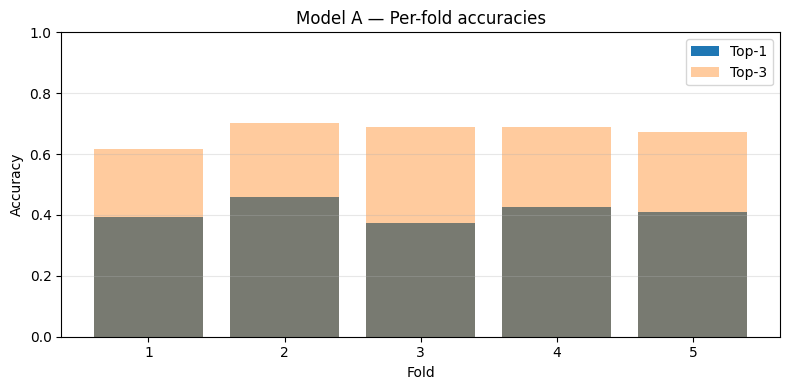

In [8]:
# =========================
# Cell 7 — A) 5-Fold Cross-Validation Runner (Model A: Spec-CNN)
# =========================
# Runs the official 5 folds, aggregates Top-1 / Top-3, and plots per-fold bars.
# Uses the spectrogram pipeline + AudioCNN defined earlier.

import time
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DEVICE = CFG["DEVICE"]

# --- Lightweight clone of the fold trainer to keep CV output compact ---
def train_eval_modelA_fold(
    fold_id: int,
    epochs: int = 12,
    batch_size: int = 64,
    lr: float = 2e-3,
    wd: float = 1e-4,
    width: int = 32,
    p_drop: float = 0.35,
    show_plots: bool = False,
):
    # loaders
    train_ld, val_ld, test_ld, sizes = make_loaders(fold_id=fold_id, batch_size=batch_size, num_workers=2)
    steps_per_epoch = len(train_ld)

    # model/opt/loss/sched
    model = AudioCNN(n_classes=CFG["N_CLASSES"], in_ch=2, width=width, p_drop=p_drop).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    try:
        criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    except TypeError:
        criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, steps_per_epoch=steps_per_epoch, epochs=epochs
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

    tr_loss_hist, va_loss_hist, tr_acc_hist, va_acc_hist = [], [], [], []
    best_val, best_state = np.inf, None
    t0 = time.time()
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_ld, optimizer, criterion, scaler, scheduler)
        va_loss, va_acc = eval_one_epoch(model, val_ld, criterion)
        tr_loss_hist.append(tr_loss); tr_acc_hist.append(tr_acc)
        va_loss_hist.append(va_loss); va_acc_hist.append(va_acc)
        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print(f"[Fold {fold_id}] Epoch {ep:02d}/{epochs} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")
    t1 = time.time()
    print(f"[Fold {fold_id}] train time: {t1-t0:.1f}s")

    if best_state is not None:
        model.load_state_dict(best_state)

    # Optional curves per fold
    if show_plots:
        fig, ax = plt.subplots(1,2, figsize=(10,3))
        ax[0].plot(tr_loss_hist, label="train"); ax[0].plot(va_loss_hist, label="val")
        ax[0].set_title(f"Loss — fold {fold_id}"); ax[0].legend(); ax[0].grid(True, alpha=0.3)
        ax[1].plot(tr_acc_hist, label="train"); ax[1].plot(va_acc_hist, label="val")
        ax[1].set_title(f"Accuracy — fold {fold_id}"); ax[1].legend(); ax[1].grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    # Test metrics
    y_true, y_pred, logits = _eval_with_logits_spec(model, test_ld)
    top1 = (y_true == y_pred).mean()
    top3 = topk_accuracy(logits, y_true, k=3)
    print(f"[Fold {fold_id}] Test — Top-1: {top1:.3f} | Top-3: {top3:.3f}")

    return {
        "fold": fold_id,
        "train_size": sizes[0],
        "val_size": sizes[1],
        "test_size": sizes[2],
        "val_best_loss": float(best_val),
        "test_top1": float(top1),
        "test_top3": float(top3),
    }, model

# --- Run all 5 folds (compact output) ---
def run_cv_modelA(epochs=12, batch_size=64, lr=2e-3, wd=1e-4, width=32, p_drop=0.35, show_plots=False):
    fold_metrics = []
    for f in [1,2,3,4,5]:
        m, _ = train_eval_modelA_fold(
            fold_id=f, epochs=epochs, batch_size=batch_size, lr=lr, wd=wd,
            width=width, p_drop=p_drop, show_plots=show_plots
        )
        fold_metrics.append(m)

    df = pd.DataFrame(fold_metrics)
    mean_top1 = df["test_top1"].mean(); std_top1 = df["test_top1"].std()
    mean_top3 = df["test_top3"].mean(); std_top3 = df["test_top3"].std()
    print("\n===== Model A — 5-Fold Summary =====")
    print(df[["fold","test_top1","test_top3"]])
    print(f"Top-1: {mean_top1:.3f} ± {std_top1:.3f} | Top-3: {mean_top3:.3f} ± {std_top3:.3f}")

    # Save CSV
    out_csv = "/kaggle/working/modelA_cv_metrics.csv"
    df.to_csv(out_csv, index=False)
    print(f"Saved per-fold metrics → {out_csv}")

    # Visuals: per-fold bars
    plt.figure(figsize=(8,4))
    plt.bar([str(i) for i in df.fold], df.test_top1, label="Top-1")
    plt.bar([str(i) for i in df.fold], df.test_top3, alpha=0.4, label="Top-3")
    plt.ylim(0,1); plt.xlabel("Fold"); plt.ylabel("Accuracy")
    plt.title("Model A — Per-fold accuracies"); plt.legend(); plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout(); plt.show()

    return df

# ---- Kick off 5-fold CV (adjust epochs if you want it faster/slower) ----
cvA_df = run_cv_modelA(epochs=10, batch_size=64, lr=2e-3, wd=1e-4, width=32, p_drop=0.35, show_plots=False)


[Upgraded Pretrained] Fold 1 sizes (train/val/test): (1440, 160, 400)
Backbone: Wav2Vec2Bundle | feat_dim: 768 | unfrozen_blocks: 4
Epoch 01/14 | train 3.6699/0.088 | val 2.9617/0.244
Epoch 02/14 | train 2.5541/0.337 | val 2.3260/0.388
Epoch 03/14 | train 2.2233/0.428 | val 2.2921/0.450
Epoch 04/14 | train 2.2669/0.449 | val 2.6982/0.369
Epoch 05/14 | train 2.0475/0.505 | val 2.4014/0.475
Epoch 06/14 | train 1.7058/0.585 | val 1.9933/0.562
Epoch 07/14 | train 1.4288/0.665 | val 1.6653/0.644
Epoch 08/14 | train 1.1368/0.760 | val 1.4827/0.675
Epoch 09/14 | train 0.9100/0.835 | val 1.5502/0.669
Epoch 10/14 | train 0.7939/0.885 | val 1.2991/0.756
Epoch 11/14 | train 0.6675/0.912 | val 1.3249/0.731
Epoch 12/14 | train 0.5789/0.953 | val 1.3108/0.762
Epoch 13/14 | train 0.5305/0.973 | val 1.2572/0.775
Epoch 14/14 | train 0.5296/0.967 | val 1.2577/0.775


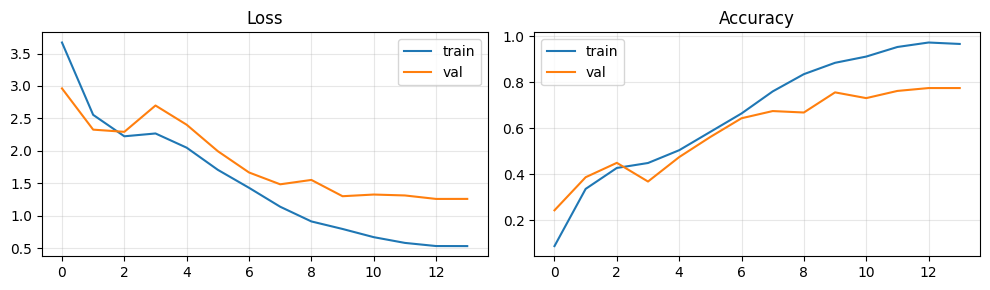

[Upgraded Pretrained] Fold 1 test accuracy: 0.672


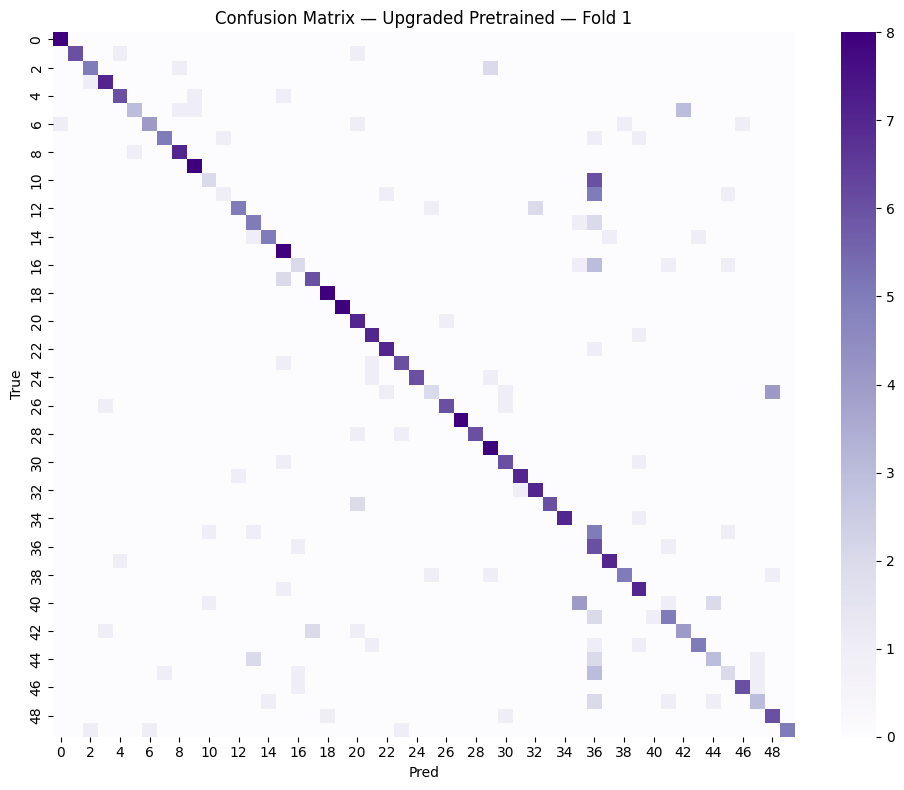

Done. Fold-1 (upgraded pretrained) accuracy: 0.6725


In [9]:
# =========================
# Cell 8 — B) Upgrade Model B (pretrained) 
#  - Attentive temporal pooling
#  - Partial unfreezing (last N transformer blocks)
#  - Discriminative LRs (backbone vs head)
#  - Longer training
# =========================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

DEVICE = CFG["DEVICE"]
TARGET_LEN = int(CFG["SAMPLE_RATE"] * CFG["MAX_SEC"])

# ---- Attentive temporal pooling (B, T, C) -> (B, C)
class AttnPool(nn.Module):
    def __init__(self, in_dim, hid=128, p_drop=0.1):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(in_dim, hid), nn.Tanh(),
            nn.Dropout(p_drop),
            nn.Linear(hid, 1)
        )
    def forward(self, x):  # x: (B, T, C)
        w = self.attn(x).squeeze(-1)                # (B, T)
        w = torch.softmax(w, dim=1)                 # attention weights
        pooled = torch.sum(x * w.unsqueeze(-1), 1)  # (B, C)
        return pooled

# ---- Helper: try to access transformer layers (torchaudio WAV2VEC/HuBERT/WavLM)
def _get_transformer_layers(m: nn.Module):
    # Try common paths
    for path in [
        "encoder.transformer.layers",
        "transformer.layers",
        "encoder.layers",
        "model.encoder.layers",
    ]:
        cur = m
        ok = True
        for p in path.split("."):
            if hasattr(cur, p):
                cur = getattr(cur, p)
            else:
                ok = False; break
        if ok and isinstance(cur, (nn.ModuleList, list)) and len(cur) > 0:
            return cur
    return None

# ---- Upgraded backbone wrapper
class PretrainedAudioUpgraded(nn.Module):
    def __init__(self, n_classes=50, freeze_backbone=True, unfreeze_last_n=0, p_drop=0.4):
        super().__init__()
        # reuse bundle resolution from earlier cell
        candidates = [
            getattr(torchaudio.pipelines, "WAV2VEC2_BASE",         None),
            getattr(torchaudio.pipelines, "WAV2VEC2_ASR_BASE_960H",None),
            getattr(torchaudio.pipelines, "HUBERT_BASE",           None),
            getattr(torchaudio.pipelines, "WAVLM_BASE",            None),
        ]
        self.backbone_name = "FallbackConv1D"
        self.backbone = None
        for bundle in candidates:
            if bundle is None: continue
            try:
                self.backbone = bundle.get_model()
                self.backbone_name = "Wav2Vec2Bundle"  # generic label
                break
            except Exception:
                self.backbone = None

        self.feat_dim = None
        if self.backbone is None:
            # fallback conv frontend
            self.backbone = nn.Sequential(
                nn.Conv1d(1, 64, 11, 5, 5), nn.BatchNorm1d(64), nn.ReLU(True),
                nn.Conv1d(64,128, 9, 4, 4), nn.BatchNorm1d(128), nn.ReLU(True),
                nn.Conv1d(128,256,7, 2, 3), nn.BatchNorm1d(256), nn.ReLU(True),
            )
            self.pool = AttnPool(256, hid=128, p_drop=0.1)
            self.head = nn.Sequential(
                nn.LayerNorm(256),
                nn.Dropout(p_drop),
                nn.Linear(256, n_classes),
            )
            self._forward_feats = self._forward_feats_conv
            self.feat_dim = 256
            self.unfrozen = 0
        else:
            # (optionally) freeze everything first
            for p in self.backbone.parameters():
                p.requires_grad_(not freeze_backbone)

            # unfreeze last N transformer blocks if requested
            self.unfrozen = 0
            if unfreeze_last_n > 0:
                layers = _get_transformer_layers(self.backbone)
                if layers is not None:
                    for block in layers[-unfreeze_last_n:]:
                        for p in block.parameters():
                            p.requires_grad_(True)
                    self.unfrozen = unfreeze_last_n

            # feature forward
            def _forward_feats_bundle(wav: torch.Tensor):
                if hasattr(self.backbone, "extract_features"):
                    feats, _ = self.backbone.extract_features(wav)  # list of (B, T, C)
                    x = feats[-1]
                else:
                    x = self.backbone(wav)  # (B, T, C)
                return x
            self._forward_feats = _forward_feats_bundle

            # infer feat_dim
            with torch.no_grad():
                d = torch.zeros(2, TARGET_LEN)
                x = self._forward_feats(d)
                self.feat_dim = x.shape[-1]

            self.pool = AttnPool(self.feat_dim, hid=256, p_drop=0.1)
            self.head = nn.Sequential(
                nn.LayerNorm(self.feat_dim),
                nn.Dropout(p_drop),
                nn.Linear(self.feat_dim, n_classes),
            )

    def _forward_feats_conv(self, wav: torch.Tensor):
        x = wav.unsqueeze(1)         # (B,1,T)
        x = self.backbone(x)         # (B,C,T)
        x = x.transpose(1,2)         # -> (B,T,C)
        return x

    def forward(self, wav):
        x = self._forward_feats(wav) # (B,T,C)
        x = self.pool(x)             # (B,C)
        return self.head(x)

# ---- Training / eval re-use
def train_one_epoch_w(model, loader, optimizer, criterion, scaler, scheduler=None):
    model.train(); tot_loss=tot_acc=n=0
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True); yb = yb.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        scaler.step(optimizer); scaler.update()
        if scheduler is not None: scheduler.step()
        bs = xb.size(0)
        tot_loss += loss.item()*bs
        tot_acc  += (logits.argmax(1)==yb).float().sum().item()
        n += bs
    return tot_loss/n, tot_acc/n

@torch.no_grad()
def eval_one_epoch_w(model, loader, criterion):
    model.eval(); tot_loss=tot_acc=n=0
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True); yb = yb.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)
        bs = xb.size(0)
        tot_loss += loss.item()*bs
        tot_acc  += (logits.argmax(1)==yb).float().sum().item()
        n += bs
    return tot_loss/n, tot_acc/n

@torch.no_grad()
def predict_all_w(model, loader):
    model.eval(); yp=[]; yt=[]
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb)
        yp.extend(logits.argmax(1).cpu().tolist())
        yt.extend(yb.cpu().tolist())
    return np.array(yt), np.array(yp)

# ---- Fit upgraded Model B on one fold (fold=1 by default)
def fit_fold_pretrained_upgraded(
    fold_id=1, epochs=14, batch_size=16, lr_head=2e-3, lr_backbone=5e-4, wd=1e-4, unfreeze_last_n=4
):
    train_ld, val_ld, test_ld, sizes = make_wave_loaders(fold_id=fold_id, batch_size=batch_size, num_workers=2)
    print(f"[Upgraded Pretrained] Fold {fold_id} sizes (train/val/test): {sizes}")

    model = PretrainedAudioUpgraded(
        n_classes=CFG["N_CLASSES"], freeze_backbone=True, unfreeze_last_n=unfreeze_last_n, p_drop=0.4
    ).to(DEVICE)
    print("Backbone:", model.backbone_name, "| feat_dim:", model.feat_dim, "| unfrozen_blocks:", model.unfrozen)

    # discriminative LRs
    head_params = list(model.head.parameters()) + list(model.pool.parameters())
    bb_params = [p for n,p in model.named_parameters() if ("backbone" in n and p.requires_grad)]
    param_groups = [
        {"params": head_params, "lr": lr_head},
        {"params": bb_params,   "lr": lr_backbone},
    ]
    optimizer = torch.optim.AdamW(param_groups, weight_decay=wd)

    try:
        criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    except TypeError:
        criterion = nn.CrossEntropyLoss()

    steps = len(train_ld)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=[lr_head, lr_backbone], steps_per_epoch=steps, epochs=epochs
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

    tr_loss_hist, va_loss_hist, tr_acc_hist, va_acc_hist = [], [], [], []
    best_val, best_state = np.inf, None
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch_w(model, train_ld, optimizer, criterion, scaler, scheduler)
        va_loss, va_acc = eval_one_epoch_w(model, val_ld, criterion)
        tr_loss_hist.append(tr_loss); tr_acc_hist.append(tr_acc)
        va_loss_hist.append(va_loss); va_acc_hist.append(va_acc)
        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        print(f"Epoch {ep:02d}/{epochs} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    torch.save(model.state_dict(), f"/kaggle/working/modelB_upgraded_fold{fold_id}.pt")

    # Curves
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    ax[0].plot(tr_loss_hist, label="train"); ax[0].plot(va_loss_hist, label="val")
    ax[0].set_title("Loss"); ax[0].legend(); ax[0].grid(True, alpha=0.3)
    ax[1].plot(tr_acc_hist, label="train"); ax[1].plot(va_acc_hist, label="val")
    ax[1].set_title("Accuracy"); ax[1].legend(); ax[1].grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # Test
    yt, yp = predict_all_w(model, test_ld)
    acc = (yt==yp).mean()
    print(f"[Upgraded Pretrained] Fold {fold_id} test accuracy: {acc:.3f}")

    cm = confusion_matrix(yt, yp, labels=list(range(CFG["N_CLASSES"])))
    plt.figure(figsize=(10,8)); sns.heatmap(cm, cmap="Purples", cbar=True)
    plt.title(f"Confusion Matrix — Upgraded Pretrained — Fold {fold_id}")
    plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout(); plt.show()

    return model, acc

# ---- Run on fold 1 (tune batch_size if VRAM is tight) ----
modelB_up, fold1_acc_B_up = fit_fold_pretrained_upgraded(
    fold_id=1, epochs=14, batch_size=16, lr_head=2e-3, lr_backbone=5e-4, wd=1e-4, unfreeze_last_n=4
)
print("Done. Fold-1 (upgraded pretrained) accuracy:", fold1_acc_B_up)

[ModelA-Pro LOWMEM] Fold 1 sizes (train/val/test): (1440, 160, 400)
Using batch_size=24, accum_steps=2, width=40
Epoch 01/14 | train 3.8104/0.042 | val 3.4890/0.056
Epoch 02/14 | train 3.3618/0.095 | val 3.1695/0.119
Epoch 03/14 | train 3.1789/0.138 | val 2.9225/0.181
Epoch 04/14 | train 3.0135/0.180 | val 2.7818/0.219
Epoch 05/14 | train 2.8578/0.218 | val 2.7581/0.231
Epoch 06/14 | train 2.7191/0.275 | val 2.8144/0.231
Epoch 07/14 | train 2.6214/0.300 | val 2.3497/0.356
Epoch 08/14 | train 2.4571/0.351 | val 2.2113/0.456
Epoch 09/14 | train 2.4524/0.377 | val 2.1646/0.406
Epoch 10/14 | train 2.4361/0.396 | val 2.0776/0.487
Epoch 11/14 | train 2.3204/0.416 | val 2.0476/0.475
Epoch 12/14 | train 2.2439/0.431 | val 1.9739/0.519
Epoch 13/14 | train 2.2219/0.467 | val 1.9613/0.544
Epoch 14/14 | train 2.2525/0.443 | val 1.9665/0.544
[ModelA-Pro LOWMEM] Fold 1 test accuracy: 0.468


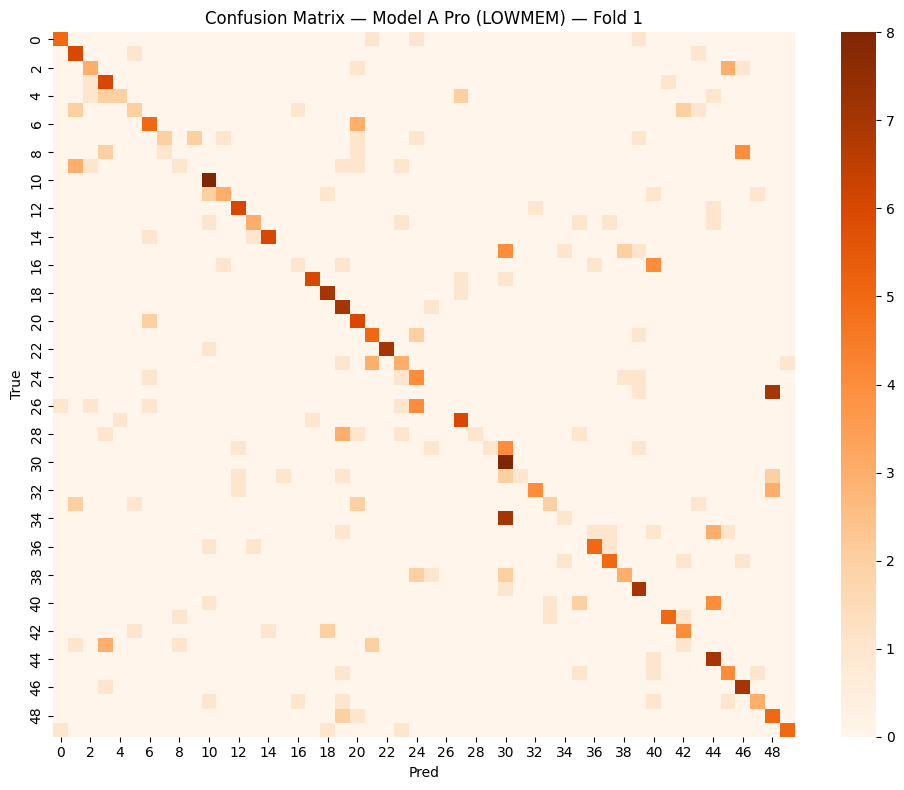

Done. Fold-1 (Model A Pro, LOWMEM) accuracy: 0.4675
Running TTA for Model A Pro …
Model A Pro — TTA Top-1: 0.463 | Top-3: 0.677
[WARN] modelB_up not found — skipping Model B TTA.
Saved per-file predictions → /kaggle/working/preds_fold1_tta_ensemble.csv


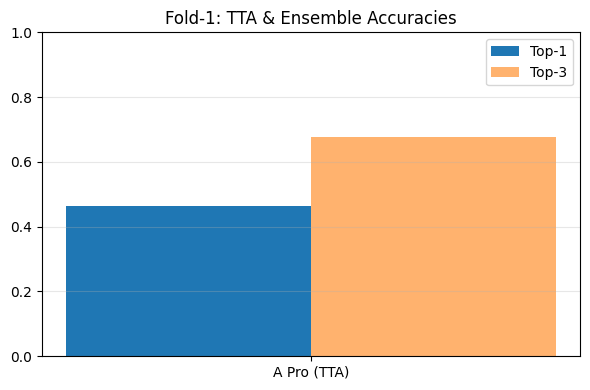

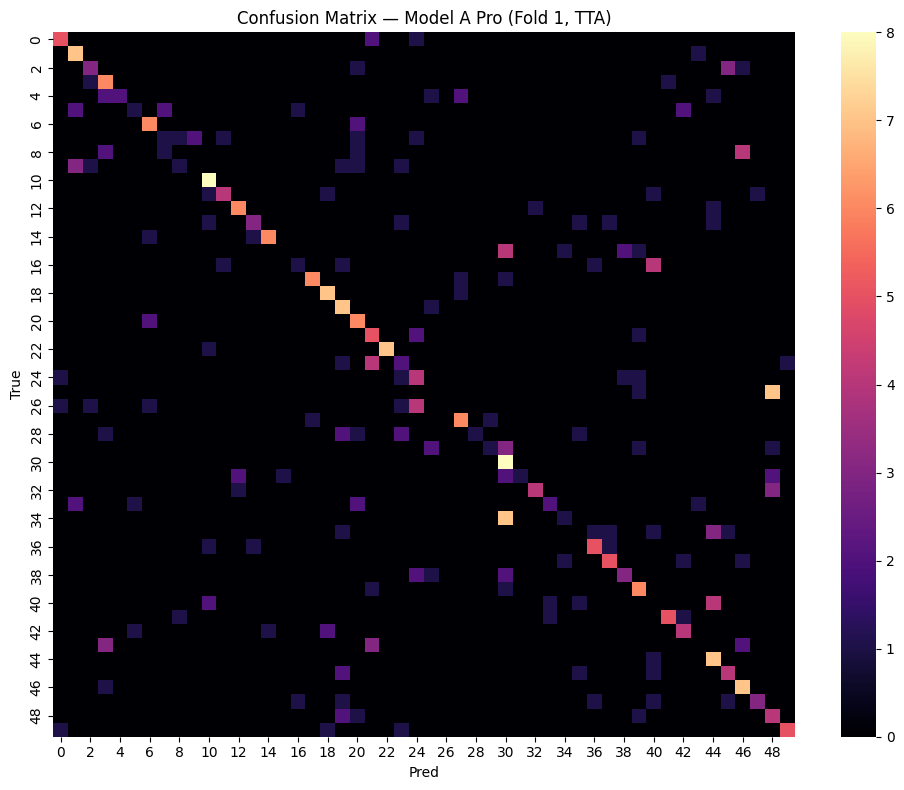

Exported Model A Pro (TorchScript) → /kaggle/working/exports/modelA_pro_scripted.pt


In [15]:
# =========================
# Cell 9+10 — Model A Pro (BC-ResNet-8) + TTA, Ensemble, Exports (ALL-IN-ONE)
# =========================
# What this cell does:
# 1) Upgraded Model A: BC-ResNet-8 (depthwise + SE + residual), strong SpecAugment, Mixup, Cosine LR
# 2) Low-memory training (channels_last, grad accumulation) to avoid OOM on Kaggle T4
# 3) TTA inference for Model A Pro (spec) and Model B Upgraded (wave) if available
# 4) A+B weighted ensemble, per-file CSV, and model exports (TorchScript if possible)

import os, gc, math, time, json
from copy import deepcopy
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# -------- Sanity: check base symbols from earlier cells --------
assert "CFG" in globals() and "AUDIOCFG" in globals() and "meta" in globals(), \
    "Please run the earlier setup/feature cells first (CFG, AUDIOCFG, meta must exist)."
assert "ESC50Dataset" in globals() and "collate_spec" in globals() and "get_fold_split" in globals(), \
    "Please run the dataset/loader cells first."
assert "torchaudio" in globals() and "_to_mono" in globals() and "_resample_if_needed" in globals() and "_ensure_length" in globals(), \
    "Please run the feature pipeline cell first."

DEVICE = CFG["DEVICE"]
FOLD_ID = 1
TARGET_LEN = int(CFG["SAMPLE_RATE"] * CFG["MAX_SEC"])

# ==============================================================
# 1) Upgraded Model A: BC-ResNet-8
# ==============================================================

# Stronger SpecAugment config
AUDIOCFG_STRONG = deepcopy(AUDIOCFG)
AUDIOCFG_STRONG.freq_mask_param = 12
AUDIOCFG_STRONG.time_mask_param = 60
AUDIOCFG_STRONG.n_freq_masks = 2
AUDIOCFG_STRONG.n_time_masks = 2

# BC-ResNet-8 components
class _DWConv(nn.Module):
    def __init__(self, c_in, k=3, s=(1,1), p=1):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_in, kernel_size=k, stride=s, padding=p, groups=c_in, bias=False)
        self.bn   = nn.BatchNorm2d(c_in)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class _PWConv(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, kernel_size=1, bias=False)
        self.bn   = nn.BatchNorm2d(c_out)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class _SEBlock(nn.Module):
    def __init__(self, ch, r=8):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1  = nn.Conv2d(ch, max(8, ch//r), 1)
        self.fc2  = nn.Conv2d(max(8, ch//r), ch, 1)
    def forward(self, x):
        w = self.pool(x)
        w = F.relu(self.fc1(w), inplace=True)
        w = torch.sigmoid(self.fc2(w))
        return x * w

class _BCResBlock(nn.Module):
    def __init__(self, c_in, c_out, stride=(1,1)):
        super().__init__()
        self.down = None
        if stride != (1,1) or c_in != c_out:
            self.down = nn.Sequential(
                nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(c_out)
            )
        self.body = nn.Sequential(
            _DWConv(c_in, k=3, s=stride, p=1),
            _PWConv(c_in, c_out),
            _SEBlock(c_out),
        )
    def forward(self, x):
        y = self.body(x)
        r = x if self.down is None else self.down(x)
        return F.relu(y + r, inplace=True)

class BCResNet8(nn.Module):
    def __init__(self, n_classes=50, in_ch=2, width=48, drop=0.35):
        super().__init__()
        c1, c2, c3, c4 = width, width*2, width*3, width*4
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, c1, 5, 1, 2, bias=False),
            nn.BatchNorm2d(c1),
            nn.ReLU(inplace=True),
        )
        self.stage1 = nn.Sequential(
            _BCResBlock(c1, c1, stride=(1,1)),
            _BCResBlock(c1, c1, stride=(1,1)),
        )
        self.stage2 = nn.Sequential(
            _BCResBlock(c1, c2, stride=(2,2)),
            _BCResBlock(c2, c2, stride=(1,1)),
        )
        self.stage3 = nn.Sequential(
            _BCResBlock(c2, c3, stride=(2,2)),
            _BCResBlock(c3, c3, stride=(1,1)),
        )
        self.stage4 = nn.Sequential(
            _BCResBlock(c3, c4, stride=(2,2)),
            _BCResBlock(c4, c4, stride=(1,1)),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1),
            nn.Dropout(drop),
            nn.Linear(c4, n_classes),
        )
    def forward(self, x):  # (B,2,64,T)
        x = self.stem(x)
        x = self.stage1(x); x = self.stage2(x); x = self.stage3(x); x = self.stage4(x)
        return self.head(x)

# Strong loaders reusing ESC50Dataset with strong SpecAugment
def make_loaders_strong(fold_id: int, batch_size: int = 64, num_workers: int = 2):
    train_df, val_df, test_df = get_fold_split(meta, fold_id)
    train_ds = ESC50Dataset(train_df, AUDIOCFG_STRONG, augment=True)
    val_ds   = ESC50Dataset(val_df,   AUDIOCFG_STRONG, augment=False)
    test_ds  = ESC50Dataset(test_df,  AUDIOCFG_STRONG, augment=False)
    args = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers>0))
    return (
        tud.DataLoader(train_ds, shuffle=True,  collate_fn=collate_spec, **args),
        tud.DataLoader(val_ds,   shuffle=False, collate_fn=collate_spec, **args),
        tud.DataLoader(test_ds,  shuffle=False, collate_fn=collate_spec, **args),
        (len(train_ds), len(val_ds), len(test_ds))
    )

# Mixup utilities (feature space)
def mixup_batch_v2(x, y, alpha=0.3, p=0.6):
    if alpha <= 0 or np.random.rand() > p:
        return x, None, None  # no mixup
    lam = float(np.random.beta(alpha, alpha))
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1.0 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return x_mix, (y_a, y_b), lam

def mixup_loss_v2(criterion, logits, y_pair, lam):
    y_a, y_b = y_pair
    return lam * criterion(logits, y_a) + (1.0 - lam) * criterion(logits, y_b)

# Low-memory train/eval (channels_last + grad accumulation)
def train_one_epoch_mixup_lowmem(model, loader, optimizer, criterion, scaler, accum_steps=2):
    model.train()
    tot_loss=tot_acc=n=0
    optimizer.zero_grad(set_to_none=True)
    for step, (xb, yb) in enumerate(loader, 1):
        xb = xb.to(DEVICE, non_blocking=True).contiguous(memory_format=torch.channels_last)
        yb = yb.to(DEVICE, non_blocking=True)
        xb, y_pair, lam = mixup_batch_v2(xb, yb, alpha=0.25, p=0.5)

        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(xb)
            if y_pair is None:
                loss = criterion(logits, yb)
                acc  = (logits.argmax(1)==yb).float().mean()
            else:
                loss = mixup_loss_v2(criterion, logits, y_pair, lam)
                acc  = (lam*(logits.argmax(1)==y_pair[0]) + (1-lam)*(logits.argmax(1)==y_pair[1])).float().mean()
            loss = loss / accum_steps

        scaler.scale(loss).backward()
        if step % accum_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(optimizer); scaler.update()
            optimizer.zero_grad(set_to_none=True)

        bs = xb.size(0)
        tot_loss += loss.item()*accum_steps*bs
        tot_acc  += acc.item()*bs
        n += bs

        del xb
        torch.cuda.empty_cache()
    return tot_loss/n, tot_acc/n

@torch.no_grad()
def eval_one_epoch_plain_lowmem(model, loader, criterion):
    model.eval()
    tot_loss=tot_acc=n=0
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True).contiguous(memory_format=torch.channels_last)
        yb = yb.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)
        bs = xb.size(0)
        tot_loss += loss.item()*bs
        tot_acc  += (logits.argmax(1)==yb).float().sum().item()
        n += bs
        del xb
    return tot_loss/n, tot_acc/n

@torch.no_grad()
def predict_all_spec_lowmem(model, loader):
    model.eval(); yt=[]; yp=[]
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True).contiguous(memory_format=torch.channels_last)
        logits = model(xb)
        yp.extend(logits.argmax(1).cpu().tolist())
        yt.extend(yb.cpu().tolist())
        del xb
    return np.array(yt), np.array(yp)

def fit_fold_modelA_pro_lowmem(
    fold_id=1, epochs=14, batch_size=24, width=40, drop=0.35, lr=3e-3, wd=1e-4, accum_steps=2
):
    # free as much as possible
    for name in ["modelA", "modelB", "modelB_up", "modelA_pro"]:
        if name in globals() and isinstance(globals()[name], nn.Module):
            try: globals()[name].to("cpu")
            except: pass
            del globals()[name]
    torch.cuda.empty_cache(); gc.collect()

    train_ld, val_ld, test_ld, sizes = make_loaders_strong(fold_id, batch_size=batch_size, num_workers=0)
    print(f"[ModelA-Pro LOWMEM] Fold {fold_id} sizes (train/val/test): {sizes}")
    print(f"Using batch_size={batch_size}, accum_steps={accum_steps}, width={width}")

    model = BCResNet8(n_classes=CFG["N_CLASSES"], in_ch=2, width=width, drop=drop).to(DEVICE)
    model = model.to(memory_format=torch.channels_last)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    try:
        criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    except TypeError:
        criterion = nn.CrossEntropyLoss()

    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    tr_loss_hist=[]; tr_acc_hist=[]; va_loss_hist=[]; va_acc_hist=[]
    best_val = np.inf; best_state=None

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch_mixup_lowmem(model, train_ld, optimizer, criterion, scaler, accum_steps=accum_steps)
        va_loss, va_acc = eval_one_epoch_plain_lowmem(model, val_ld, criterion)
        tr_loss_hist.append(tr_loss); tr_acc_hist.append(tr_acc)
        va_loss_hist.append(va_loss); va_acc_hist.append(va_acc)
        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        scheduler.step()
        print(f"Epoch {ep:02d}/{epochs} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")
        torch.cuda.empty_cache(); gc.collect()

    if best_state is not None:
        model.load_state_dict(best_state)
    torch.save(model.state_dict(), f"/kaggle/working/modelA_pro_lowmem_fold{fold_id}.pt")

    # Test
    yt, yp = predict_all_spec_lowmem(model, test_ld)
    acc = (yt==yp).mean()
    print(f"[ModelA-Pro LOWMEM] Fold {fold_id} test accuracy: {acc:.3f}")

    # Confusion matrix
    cm = confusion_matrix(yt, yp, labels=list(range(CFG["N_CLASSES"])))
    plt.figure(figsize=(10,8)); sns.heatmap(cm, cmap="Oranges", cbar=True)
    plt.title(f"Confusion Matrix — Model A Pro (LOWMEM) — Fold {fold_id}")
    plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout(); plt.show()

    return model, acc

# ---- Train Model A Pro on fold 1 (lowmem-friendly defaults) ----
modelA_pro, fold1_acc_A_pro = fit_fold_modelA_pro_lowmem(
    fold_id=FOLD_ID,
    epochs=14,
    batch_size=24,
    width=40,
    drop=0.35,
    lr=3e-3,
    wd=1e-4,
    accum_steps=2
)
print("Done. Fold-1 (Model A Pro, LOWMEM) accuracy:", fold1_acc_A_pro)

# ==============================================================
# 2) Extras: TTA for Model A Pro & Model B Upgraded, Ensemble, CSV, Exports
# ==============================================================

# Helpers for TTA (spec + wave)
@torch.no_grad()
def _load_wav_fixed(path: str, sr_out: int) -> torch.Tensor:
    wav, sr = torchaudio.load(path)        # (C,N)
    wav = _to_mono(wav)
    wav = _resample_if_needed(wav, sr, sr_out)
    wav = _ensure_length(wav, int(sr_out * CFG["MAX_SEC"]))
    return wav.squeeze(0)                   # (T,)

@torch.no_grad()
def _shift_wav(wav_1d: torch.Tensor, shift_sec: float, sr: int) -> torch.Tensor:
    if shift_sec == 0.0: return wav_1d
    shift = int(shift_sec * sr)
    return torch.roll(wav_1d, shifts=shift)

@torch.no_grad()
def _spec_from_wav_1d(wav_1d: torch.Tensor, cfg) -> torch.Tensor:
    w = wav_1d.unsqueeze(0).unsqueeze(0)         # (1,1,T)
    mel = _mel_spec(w).clamp_min(1e-10).squeeze(0).squeeze(0)  # (n_mels, T)
    mel_db = _to_db(mel)
    if getattr(cfg, "use_pcen", True):
        pcen = _apply_pcen(mel, cfg)
        feats = torch.stack([mel_db, pcen], dim=0)             # (2, n_mels, T)
    else:
        feats = mel_db.unsqueeze(0)
    # per-channel standardization
    C = feats.shape[0]
    v = feats.view(C, -1)
    m = v.mean(dim=1, keepdim=True); s = v.std(dim=1, keepdim=True).clamp_min(1e-5)
    feats = ((v - m) / s).view_as(feats)
    return feats

@torch.no_grad()
def tta_logits_modelA(model, df: pd.DataFrame, shifts: List[float] = [-0.25, -0.1, 0.0, 0.1, 0.25]) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    logits_all, targets = [], []
    for _, row in df.iterrows():
        wav = _load_wav_fixed(row.filepath, CFG["SAMPLE_RATE"])
        logit_accum = None
        for sh in shifts:
            wsh = _shift_wav(wav, sh, CFG["SAMPLE_RATE"])
            feats = _spec_from_wav_1d(wsh, AUDIOCFG).to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                out = model(feats.unsqueeze(0))  # (1,50)
            logit_accum = out if logit_accum is None else (logit_accum + out)
        logits_all.append((logit_accum/len(shifts)).squeeze(0).cpu().numpy())
        targets.append(int(row.target))
    return np.stack(logits_all, 0), np.array(targets)

@torch.no_grad()
def tta_logits_modelB(model, df: pd.DataFrame, shifts: List[float] = [-0.2, -0.1, 0.0, 0.1, 0.2]) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    logits_all, targets = [], []
    for _, row in df.iterrows():
        wav = _load_wav_fixed(row.filepath, CFG["SAMPLE_RATE"])
        logit_accum = None
        for sh in shifts:
            wsh = _shift_wav(wav, sh, CFG["SAMPLE_RATE"]).to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                out = model(wsh.unsqueeze(0))  # (1,50)
            logit_accum = out if logit_accum is None else (logit_accum + out)
        logits_all.append((logit_accum/len(shifts)).squeeze(0).cpu().numpy())
        targets.append(int(row.target))
    return np.stack(logits_all, 0), np.array(targets)

def _topk_acc(logits: np.ndarray, y: np.ndarray, k: int = 3) -> float:
    topk = np.argpartition(-logits, kth=range(k), axis=1)[:, :k]
    return (topk == y.reshape(-1,1)).any(axis=1).mean()

# Build test df for the chosen fold
test_df = meta[meta.fold == FOLD_ID].reset_index(drop=True)

# TTA — Model A Pro
print("Running TTA for Model A Pro …")
logits_A, y_true = tta_logits_modelA(modelA_pro, test_df, shifts=[-0.25, -0.1, 0.0, 0.1, 0.25])
acc_A_tta  = (logits_A.argmax(1) == y_true).mean()
top3_A_tta = _topk_acc(logits_A, y_true, k=3)
print(f"Model A Pro — TTA Top-1: {acc_A_tta:.3f} | Top-3: {top3_A_tta:.3f}")

# TTA — Model B Upgraded (if available)
have_modelB = "modelB_up" in globals() and isinstance(modelB_up, nn.Module)
if have_modelB:
    print("Running TTA for Model B Upgraded …")
    logits_B, y_true_B = tta_logits_modelB(modelB_up, test_df, shifts=[-0.2, -0.1, 0.0, 0.1, 0.2])
    assert np.allclose(y_true, y_true_B), "Targets mismatch between A and B pipelines."
    acc_B_tta  = (logits_B.argmax(1) == y_true).mean()
    top3_B_tta = _topk_acc(logits_B, y_true, k=3)
    print(f"Model B Up — TTA Top-1: {acc_B_tta:.3f} | Top-3: {top3_B_tta:.3f}")
else:
    print("[WARN] modelB_up not found — skipping Model B TTA.")
    logits_B = None

# Ensemble (if B is available)
if logits_B is not None:
    wA, wB = 0.4, 0.6
    logits_ens = wA*logits_A + wB*logits_B
    acc_ens  = (logits_ens.argmax(1) == y_true).mean()
    top3_ens = _topk_acc(logits_ens, y_true, k=3)
    print(f"Ensemble (wA={wA}, wB={wB}) — Top-1: {acc_ens:.3f} | Top-3: {top3_ens:.3f}")
else:
    logits_ens, acc_ens, top3_ens = None, None, None

# Save per-file predictions CSV
pred_A   = logits_A.argmax(1)
pred_B   = logits_B.argmax(1) if logits_B is not None else np.full_like(pred_A, -1)
pred_ens = logits_ens.argmax(1) if logits_ens is not None else pred_A

out_df = pd.DataFrame({
    "filename": test_df.filename.values,
    "true_idx": y_true,
    "true_label": [IDX2LABEL[i] for i in y_true],
    "predA_idx": pred_A,
    "predA_label": [IDX2LABEL[i] for i in pred_A],
})
if logits_B is not None:
    out_df["predB_idx"]    = pred_B
    out_df["predB_label"]  = [IDX2LABEL[i] for i in pred_B]
if logits_ens is not None:
    out_df["predENS_idx"]   = pred_ens
    out_df["predENS_label"] = [IDX2LABEL[i] for i in pred_ens]

csv_path = "/kaggle/working/preds_fold1_tta_ensemble.csv"
out_df.to_csv(csv_path, index=False)
print(f"Saved per-file predictions → {csv_path}")

# Quick bar plot (Top-1/Top-3)
labels = ["A Pro (TTA)"]
top1s  = [acc_A_tta]
top3s  = [top3_A_tta]
if logits_B is not None:
    labels += ["B Up (TTA)"]; top1s += [acc_B_tta]; top3s += [top3_B_tta]
if logits_ens is not None:
    labels += ["Ensemble"]; top1s += [acc_ens]; top3s += [top3_ens]

plt.figure(figsize=(6,4))
x = np.arange(len(labels))
plt.bar(x-0.18, top1s, width=0.36, label="Top-1")
plt.bar(x+0.18, top3s, width=0.36, label="Top-3", alpha=0.6)
plt.ylim(0,1); plt.xticks(x, labels, rotation=0)
plt.title("Fold-1: TTA & Ensemble Accuracies")
plt.legend(); plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout(); plt.show()

# Confusion matrix for Ensemble (or Model A Pro if no ensemble)
use_logits = logits_ens if logits_ens is not None else logits_A
pred_used  = use_logits.argmax(1)
cm = confusion_matrix(y_true, pred_used, labels=list(range(CFG["N_CLASSES"])))
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="magma", cbar=True)
ttl = "Ensemble (Fold 1, TTA)" if logits_ens is not None else "Model A Pro (Fold 1, TTA)"
plt.title(f"Confusion Matrix — {ttl}")
plt.xlabel("Pred"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# Exports
os.makedirs("/kaggle/working/exports", exist_ok=True)
# Model A Pro export (expects input: (B,2,64,T))
try:
    _A_cpu = modelA_pro.to("cpu").eval()
    scripted_A = torch.jit.script(_A_cpu)
    path_A = "/kaggle/working/exports/modelA_pro_scripted.pt"
    scripted_A.save(path_A)
    print(f"Exported Model A Pro (TorchScript) → {path_A}")
    del scripted_A, _A_cpu
except Exception as e:
    path_A_sd = "/kaggle/working/exports/modelA_pro_state_dict.pth"
    torch.save(modelA_pro.state_dict(), path_A_sd)
    print(f"[WARN] TorchScript export failed for Model A Pro; saved state_dict instead → {path_A_sd}\n{e}")

# Model B Upgraded export (expects input: (B,T))
if have_modelB:
    try:
        _B_cpu = modelB_up.to("cpu").eval()
        scripted_B = torch.jit.script(_B_cpu)
        path_B = "/kaggle/working/exports/modelB_up_scripted.pt"
        scripted_B.save(path_B)
        print(f"Exported Model B Upgraded (TorchScript) → {path_B}")
        del scripted_B, _B_cpu
    except Exception as e:
        path_B_sd = "/kaggle/working/exports/modelB_up_state_dict.pth"
        torch.save(modelB_up.state_dict(), path_B_sd)
        print(f"[WARN] TorchScript export failed for Model B Upgraded; saved state_dict instead → {path_B_sd}\n{e}")

gc.collect(); torch.cuda.empty_cache()

Reloaded Model B Upgraded from: /kaggle/working/modelB_upgraded_fold1.pt
Running TTA for Model B Upgraded …
Model A Pro — TTA Top-1: 0.463 | Top-3: 0.677
Model B Up  — TTA Top-1: 0.660 | Top-3: 0.840
Ensemble (wA=0.4, wB=0.6) — Top-1: 0.708 | Top-3: 0.860
Saved per-file predictions → /kaggle/working/preds_fold1_tta_ensemble_withB.csv


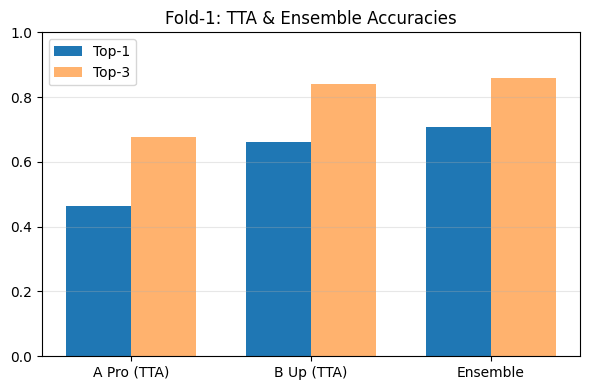

In [16]:
# =========================
# Cell 10.reload — Reload Model B, re-run TTA & Ensemble, save CSV
# =========================

import os, numpy as np, pandas as pd, torch, torch.nn as nn
import matplotlib.pyplot as plt

DEVICE = CFG["DEVICE"]
FOLD_ID = 1
ckpt_B = f"/kaggle/working/modelB_upgraded_fold{FOLD_ID}.pt"

# ---- 1) Ensure Model B Upgraded is in memory (no retraining)
if "PretrainedAudioUpgraded" not in globals():
    raise RuntimeError("PretrainedAudioUpgraded class not found. Please re-run Cell 8 first.")
if not os.path.exists(ckpt_B):
    raise FileNotFoundError(f"Checkpoint not found at {ckpt_B}. Re-run Cell 8 to train & save it.")

modelB_up = PretrainedAudioUpgraded(
    n_classes=CFG["N_CLASSES"], freeze_backbone=True, unfreeze_last_n=4, p_drop=0.4
).to(DEVICE).eval()
state = torch.load(ckpt_B, map_location=DEVICE)
modelB_up.load_state_dict(state)
print("Reloaded Model B Upgraded from:", ckpt_B)

# ---- 2) Build test df and make sure TTA helpers exist
test_df = meta[meta.fold == FOLD_ID].reset_index(drop=True)

if "tta_logits_modelA" not in globals() or "tta_logits_modelB" not in globals():
    raise RuntimeError("TTA helpers not found. Please run the earlier 9+10 cell first.")

# If Model A TTA logits not present, recompute quickly
recompute_A = ("logits_A" not in globals()) or ("y_true" not in globals())
if recompute_A:
    print("Recomputing TTA for Model A Pro …")
    logits_A, y_true = tta_logits_modelA(modelA_pro, test_df, shifts=[-0.25, -0.1, 0.0, 0.1, 0.25])

# ---- 3) TTA for Model B, then ensemble
print("Running TTA for Model B Upgraded …")
logits_B, y_true_B = tta_logits_modelB(modelB_up, test_df, shifts=[-0.2, -0.1, 0.0, 0.1, 0.2])

assert np.allclose(y_true, y_true_B), "Targets mismatch between A and B pipelines."

def _topk_acc(logits, y, k=3):
    topk = np.argpartition(-logits, kth=range(k), axis=1)[:, :k]
    return (topk == y.reshape(-1,1)).any(axis=1).mean()

acc_A  = (logits_A.argmax(1) == y_true).mean()
acc_B  = (logits_B.argmax(1) == y_true).mean()
top3_A = _topk_acc(logits_A, y_true, 3)
top3_B = _topk_acc(logits_B, y_true, 3)

# Weight the stronger model a bit more
wA, wB = 0.4, 0.6
logits_ens = wA*logits_A + wB*logits_B
acc_ens  = (logits_ens.argmax(1) == y_true).mean()
top3_ens = _topk_acc(logits_ens, y_true, 3)

print(f"Model A Pro — TTA Top-1: {acc_A:.3f} | Top-3: {top3_A:.3f}")
print(f"Model B Up  — TTA Top-1: {acc_B:.3f} | Top-3: {top3_B:.3f}")
print(f"Ensemble (wA={wA}, wB={wB}) — Top-1: {acc_ens:.3f} | Top-3: {top3_ens:.3f}")

# ---- 4) Save per-file predictions CSV
pred_A   = logits_A.argmax(1)
pred_B   = logits_B.argmax(1)
pred_ens = logits_ens.argmax(1)

out_df = pd.DataFrame({
    "filename": test_df.filename.values,
    "true_idx": y_true,
    "true_label": [IDX2LABEL[i] for i in y_true],
    "predA_idx": pred_A,
    "predA_label": [IDX2LABEL[i] for i in pred_A],
    "predB_idx": pred_B,
    "predB_label": [IDX2LABEL[i] for i in pred_B],
    "predENS_idx": pred_ens,
    "predENS_label": [IDX2LABEL[i] for i in pred_ens],
})
csv_path = "/kaggle/working/preds_fold1_tta_ensemble_withB.csv"
out_df.to_csv(csv_path, index=False)
print(f"Saved per-file predictions → {csv_path}")

# ---- 5) Quick bar chart summary
labels = ["A Pro (TTA)", "B Up (TTA)", "Ensemble"]
top1s  = [acc_A, acc_B, acc_ens]
top3s  = [top3_A, top3_B, top3_ens]

x = np.arange(len(labels))
plt.figure(figsize=(6,4))
plt.bar(x-0.18, top1s, width=0.36, label="Top-1")
plt.bar(x+0.18, top3s, width=0.36, label="Top-3", alpha=0.6)
plt.ylim(0,1); plt.xticks(x, labels)
plt.title("Fold-1: TTA & Ensemble Accuracies")
plt.legend(); plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout(); plt.show()